In [1]:
import torch
import numpy as np
import os
from torch.utils.data import Subset
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
import random
from matplotlib import pyplot as plt


def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


seed = 42
#seed = 25
set_seed(seed)

In [2]:
from data import MIDIDataset, graph_from_tensor, graph_from_tensor_torch
from model import VAE
from utils import plot_struct, dense_from_sparse, dense_from_sparse_torch, muspy_from_dense
from utils import plot_pianoroll, midi_from_muspy
from train import VAETrainer

Load trained model:

In [3]:
models_dir = 'models/'
model = '2barsGNNDEF/'
gpu = True
device_idx = 0

checkpoint = torch.load(os.path.join(models_dir, model, 'checkpoint'), map_location='cpu')
state_dict = checkpoint['model_state_dict']
params = torch.load(os.path.join(models_dir, model, 'params'), map_location='cpu')

In [4]:
torch.cuda.set_device(device_idx)

device = torch.device("cuda") if gpu else torch.device("cpu")
print("Device:", device)
print("Device idx:", torch.cuda.current_device())

Device: cuda
Device idx: 0


In [5]:
params

{'training': {'batch_size': 256,
  'num_workers': 4,
  'ds_len': 6813946,
  'tr_len': 4769762,
  'vl_len': 681394,
  'ts_len': 1362790},
 'model': {'dropout': 0,
  'batch_norm': True,
  'gnn_n_layers': 8,
  'actsnn_n_layers': 2,
  'd': 512,
  'rnn_n_layers': 1,
  'k_isgn': 3,
  'd_token': 230,
  'd_token_pitches': 131,
  'd_token_dur': 99,
  'n_bars': 2,
  'n_relations': 6,
  'n_tracks': 4,
  'resolution': 8,
  'max_simu_notes': 16},
 'scheduler': {'peak_lr': 0.0001,
  'final_lr_scale': 0.01,
  'warmup_steps': 8000,
  'decay_steps': 800000},
 'optimizer': {'betas': (0.9, 0.98), 'eps': 1e-09, 'lr': 5e-06},
 'beta_annealing': {'beta_update': True,
  'anneal_start': 40000,
  'beta_max': 0.01,
  'step_size': 0.001,
  'anneal_end': 500000}}

In [6]:
vae = VAE(**params['model'], device=device).to(device)
vae.load_state_dict(state_dict)
vae.eval()

VAE(
  (encoder): Encoder(
    (dropout_layer): Dropout(p=0, inplace=False)
    (notes_pitch_emb): Linear(in_features=131, out_features=256, bias=True)
    (bn_npe): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drums_pitch_emb): Linear(in_features=131, out_features=256, bias=True)
    (bn_dpe): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dur_emb): Linear(in_features=99, out_features=256, bias=True)
    (bn_de): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (chord_encoder): Linear(in_features=7680, out_features=512, bias=True)
    (graph_encoder): GraphEncoder(
      (layers): ModuleList(
        (0): RGCNConv(512, 512, num_relations=6)
        (1): RGCNConv(512, 512, num_relations=6)
        (2): RGCNConv(512, 512, num_relations=6)
        (3): RGCNConv(512, 512, num_relations=6)
        (4): RGCNConv(512, 512, num_relations=6)
        (5): RGCNConv(512, 512, num_re

## Reconstruction

In [ ]:
save_dir = "models/test/"
save_dir = os.path.join(save_dir, model)

Load dataset:

In [ ]:
n_bars = params['model']['n_bars']
bs = params['training']['batch_size']
nw = 8
tr_split = 0.7
val_split = 0.1

ds_dir = "/data/cosenza/datasets/MMD/preprocessed_" + str(n_bars) + "bars_par/"
dataset = MIDIDataset(ds_dir, n_bars=n_bars)
print('Dataset len:', len(dataset))

loader = DataLoader(dataset, batch_size=bs, shuffle=False, num_workers=nw)

train_len = int(tr_split * len(dataset))
valid_len = int(val_split * len(dataset))
test_len = len(dataset) - train_len - valid_len
tr_set, vl_set, ts_set = random_split(dataset, (train_len, valid_len, test_len))

trainloader = DataLoader(tr_set, batch_size=bs, shuffle=True, num_workers=nw)
validloader = DataLoader(vl_set, batch_size=bs, shuffle=False, num_workers=nw)
testloader = DataLoader(ts_set, batch_size=bs, shuffle=False, num_workers=nw)

tr_len = len(tr_set)
vl_len = len(vl_set)
ts_len = len(ts_set)

print('TR set len:', len(tr_set))
print('VL set len:', len(vl_set))
print('TS set len:', len(ts_set))

#### Reconstruction accuracy (TS, TF)

In [ ]:
d = 'models/test'
trainer = VAETrainer(d, model=vae)

Compute TS losses and accuracies:

In [ ]:
save_dir = "models/test/"
save_dir = os.path.join(save_dir, model)
os.makedirs(save_dir, exist_ok=False)
path = os.path.join(save_dir, "ts")

In [ ]:
losses, accuracies = trainer.evaluate(testloader)

# Save results
torch.save({
    'losses': losses,
    'accuracies': accuracies
}, path)

In [ ]:
res = torch.load("models/test/16barsGNNDEF/tstf", map_location='cpu')

In [ ]:
res

In [ ]:
stats = res['accs_m']
print("{:<20} {:<10.3f}".format('pitches', stats['pitches']))
print("{:<20} {:<10.3f}".format('durations', stats['dur']))
print("{:<20} {:<10.3f}".format('ov.rec. (drums)', (stats['pitches_drums'] + stats['dur_drums'])/2))
print("{:<20} {:<10.3f}".format('ov.rec. (melody)', (stats['pitches_non_drums'] + stats['dur_non_drums'])/2))
print("{:<20} {:<10.3f}".format('ov.rec. (all)', (stats['pitches'] + stats['dur'])/2))

Losses

In [ ]:
for key, value in res['losses'].items():
    print ("{:<10} {:<10.3f}".format(key, value))

Accuracies

In [ ]:
for key, value in res['accuracies'].items():
    print ("{:<20} {:<10.1f}".format(key, value*100))
    
print()

rec = 100*((res['accuracies']['pitches'] + res['accuracies']['dur'])/2)
print("{:<20} {:<20.1f}".format('rec', rec))

#### Reconstruction accuracy (TS, no TF)

In [ ]:
import torch.nn.functional as F


def append_dict(dest_d, source_d):
        
    for k1, v1 in source_d.items():
        for k2, v2 in v1.items():
            dest_d[k1][k2].append(v2)

def _compute_accuracies(inputs, outputs):
        
        x_seq, x_acts = inputs
        seq_rec, acts_rec = outputs
        
        # Shift outputs and filter silences
        #x_seq = x_seq[..., 1:, :]
        
        
        matching = False
        
        # No matching, eos
        eos = True
        notes_acc = _note_accuracy(seq_rec, x_seq, eos=eos)
        notes_acc_drums = _note_accuracy(seq_rec, x_seq, drums=True, eos=eos)
        notes_acc_non_drums = _note_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        pitches_acc = _pitches_accuracy(seq_rec, x_seq, eos=eos)
        pitches_acc_drums = _pitches_accuracy(seq_rec, x_seq,  drums=True, eos=eos)
        pitches_acc_non_drums = _pitches_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        dur_acc = _dur_accuracy(seq_rec, x_seq, eos=eos)
        dur_acc_drums = _dur_accuracy(seq_rec, x_seq, drums=True, eos=eos)
        dur_acc_non_drums = _dur_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        rec_acc = (pitches_acc + dur_acc) / 2
        
        # No matching, no eos
        eos = False
        notes_acc_noeos = _note_accuracy(seq_rec, x_seq, eos=eos)
        notes_acc_drums_noeos = _note_accuracy(seq_rec, x_seq, drums=True, eos=eos)
        notes_acc_non_drums_noeos = _note_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        pitches_acc_noeos = _pitches_accuracy(seq_rec, x_seq, eos=eos)
        pitches_acc_drums_noeos = _pitches_accuracy(seq_rec, x_seq,  drums=True, eos=eos)
        pitches_acc_non_drums_noeos = _pitches_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        dur_acc_noeos = _dur_accuracy(seq_rec, x_seq, eos=eos)
        dur_acc_drums_noeos = _dur_accuracy(seq_rec, x_seq, drums=True, eos=eos)
        dur_acc_non_drums_noeos = _dur_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        rec_acc_noeos = (pitches_acc_noeos + dur_acc_noeos) / 2
        
        acts_acc = _acts_accuracy(acts_rec, x_acts)
        acts_precision = _acts_precision(acts_rec, x_acts)
        acts_recall = _acts_recall(acts_rec, x_acts)
        acts_f1 = (2 * acts_recall * acts_precision / 
                       (acts_recall + acts_precision))
        
        
        # Baseline
        #silence = torch.zeros(seq_rec.size(),
        #                      device=x_seq.device, dtype=x_seq.dtype)
        #silence[..., 0, 129] = 1. # pitch eos token
        #silence[..., 1:, 130] = 1. # pitch pad token
        #silence[..., 0, 228] = 1. # dur eos token
        #silence[..., 1:, 229] = 1. # dur pad token
        
        #pitches_acc_sil = _pitches_accuracy(silence, x_seq)
        
        matching = True
        
        # Matching, eos
        eos = True
        acts_rec = torch.sigmoid(acts_rec)
        acts_rec[acts_rec < 0.5] = 0
        acts_rec[acts_rec >= 0.5] = 1
        matching = (torch.logical_and(acts_rec, x_acts))
        
        matching = matching.view(seq_rec.size(0), seq_rec.size(1),
                                 matching.size(1), matching.size(2))
        
        is_drum = torch.zeros(matching.size(), dtype=matching.dtype)
        is_drum[..., 0, :] = 1
        seq_rec, x_seq = seq_rec[matching], x_seq[matching]
        is_drum = is_drum[matching]
        
        notes_acc_m = _note_accuracy(seq_rec, x_seq, eos=eos)
        notes_acc_m_drums = _note_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        notes_acc_m_non_drums = _note_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        pitches_acc_m = _pitches_accuracy(seq_rec, x_seq, eos=eos)
        pitches_acc_m_drums = _pitches_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        pitches_acc_m_non_drums = _pitches_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        dur_acc_m = _dur_accuracy(seq_rec, x_seq, eos=eos)
        dur_acc_m_drums = _dur_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        dur_acc_m_non_drums = _dur_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        rec_acc_m = (pitches_acc_m + dur_acc_m) / 2
        
        
        # Matching, no eos
        eos = False
        notes_acc_m_noeos = _note_accuracy(seq_rec, x_seq, eos=eos)
        notes_acc_m_drums_noeos = _note_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        notes_acc_m_non_drums_noeos = _note_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        pitches_acc_m_noeos = _pitches_accuracy(seq_rec, x_seq, eos=eos)
        pitches_acc_m_drums_noeos = _pitches_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        pitches_acc_m_non_drums_noeos = _pitches_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        dur_acc_m_noeos = _dur_accuracy(seq_rec, x_seq, eos=eos)
        dur_acc_m_drums_noeos = _dur_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        dur_acc_m_non_drums_noeos = _dur_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        rec_acc_m_noeos = (pitches_acc_m_noeos + dur_acc_m_noeos) / 2
        
        accs = {
            'notes': notes_acc.item(),
            'notes_drums': notes_acc_drums.item(),
            'notes_non_drums': notes_acc_non_drums.item(),

            'pitches': pitches_acc.item(),
            'pitches_drums': pitches_acc_drums.item(),
            'pitches_non_drums': pitches_acc_non_drums.item(),

            'dur': dur_acc.item(),
            'dur_drums': dur_acc_drums.item(),
            'dur_non_drums': dur_acc_non_drums.item(),
            
            'rec': rec_acc.item()
        }
        
        accs_noeos = {
            'notes': notes_acc_noeos.item(),
            'notes_drums': notes_acc_drums_noeos.item(),
            'notes_non_drums': notes_acc_non_drums_noeos.item(),

            'pitches': pitches_acc_noeos.item(),
            'pitches_drums': pitches_acc_drums_noeos.item(),
            'pitches_non_drums': pitches_acc_non_drums_noeos.item(),

            'dur': dur_acc_noeos.item(),
            'dur_drums': dur_acc_drums_noeos.item(),
            'dur_non_drums': dur_acc_non_drums_noeos.item(),
            
            'rec_noeos': rec_acc_noeos.item()
        }
        
        accs_m = {
            'notes': notes_acc_m.item(),
            'notes_drums': notes_acc_m_drums.item(),
            'notes_non_drums': notes_acc_m_non_drums.item(),
            
            'pitches': pitches_acc_m.item(),
            'pitches_drums': pitches_acc_m_drums.item(),
            'pitches_non_drums': pitches_acc_m_non_drums.item(),

            'dur': dur_acc_m.item(),
            'dur_drums': dur_acc_m_drums.item(),
            'dur_non_drums': dur_acc_m_non_drums.item(),
            
            'rec': rec_acc_m.item()
        }
        
        accs_m_noeos = {
            
            'notes': notes_acc_m_noeos.item(),
            'notes_drums': notes_acc_m_drums_noeos.item(),
            'notes_non_drums': notes_acc_m_non_drums_noeos.item(),
            
            'pitches': pitches_acc_m_noeos.item(),
            'pitches_drums': pitches_acc_m_drums_noeos.item(),
            'pitches_non_drums': pitches_acc_m_non_drums_noeos.item(),

            'dur': dur_acc_m_noeos.item(),
            'dur_drums': dur_acc_m_drums_noeos.item(),
            'dur_non_drums': dur_acc_m_non_drums_noeos.item(),
            
            'rec': rec_acc_m_noeos.item()
        }
        
        structure = {
            'acts_acc': acts_acc.item(),
            'acts_precision': acts_precision.item(),
            'acts_recall': acts_recall.item(),
            'acts_f1': acts_f1.item()
        }
        
        r = {
            'accs': accs,
            'accs_noeos': accs_noeos,
            'accs_m': accs_m,
            'accs_m_noeos': accs_m_noeos,
            'structure': structure
        }
        
        return r
    
    
def _note_accuracy(seq_rec, x_seq, drums=None, eos=True, is_drum=None):

    if drums is not None:
        if is_drum is None:
            if drums:
                seq_rec = seq_rec[..., 0, :, :, :]
                x_seq = x_seq[..., 0, :, :, :]
            else:
                seq_rec = seq_rec[..., 1:, :, :, :]
                x_seq = x_seq[..., 1:, :, :, :]
        else:
            if drums:
                seq_rec = seq_rec[is_drum]
                x_seq = x_seq[is_drum]
            else:
                seq_rec = seq_rec[torch.logical_not(is_drum)]
                x_seq = x_seq[torch.logical_not(is_drum)]

    pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
    pitches_rec = torch.argmax(pitches_rec, dim=-1)
    pitches_true = torch.argmax(x_seq[..., :131], dim=-1)

    #print(torch.all(pitches_rec == 129))
    #print(pitches_rec)

    if eos:
        mask_p = (pitches_true != 130)
    else:
        mask_p = torch.logical_and(pitches_true != 128,
                                   pitches_true != 129)
        mask_p = torch.logical_and(mask_p,
                                   pitches_true != 130)

    preds_pitches = (pitches_rec == pitches_true)
    preds_pitches = torch.logical_and(preds_pitches, mask_p)


    dur_rec = F.softmax(seq_rec[..., 131:], dim=-1)
    dur_rec = torch.argmax(dur_rec, dim=-1)
    dur_true = torch.argmax(x_seq[..., 131:], dim=-1)

    #print(torch.all(dur_rec == 97))

    if eos:
        mask_d = (dur_true != 98)
    else:
        mask_d = torch.logical_and(dur_true != 96,
                                   dur_true != 97)
        mask_d = torch.logical_and(mask_d,
                                   dur_true != 98)

    preds_dur = (dur_rec == dur_true)
    preds_dur = torch.logical_and(preds_dur, mask_d)

    return torch.sum(torch.logical_and(preds_pitches, 
                                       preds_dur)) / torch.sum(mask_p)


def _acts_precision(acts_rec, x_acts):

    acts_rec = torch.sigmoid(acts_rec)
    acts_rec[acts_rec < 0.5] = 0
    acts_rec[acts_rec >= 0.5] = 1

    tp = torch.sum(x_acts[acts_rec == 1])

    return tp / torch.sum(acts_rec)


def _acts_recall(acts_rec, x_acts):

    acts_rec = torch.sigmoid(acts_rec)
    acts_rec[acts_rec < 0.5] = 0
    acts_rec[acts_rec >= 0.5] = 1

    tp = torch.sum(x_acts[acts_rec == 1])

    return tp / torch.sum(x_acts)


def _acts_accuracy(acts_rec, x_acts):

    acts_rec = torch.sigmoid(acts_rec)
    acts_rec[acts_rec < 0.5] = 0
    acts_rec[acts_rec >= 0.5] = 1

    #print("All zero acts?", torch.all(acts_rec == 0))
    #print("All one acts?", torch.all(acts_rec == 0))

    return torch.sum(acts_rec == x_acts) / x_acts.numel()


def _pitches_accuracy(seq_rec, x_seq, drums=None, eos=True, is_drum=None):

    if drums is not None:
        if is_drum is None:
            if drums:
                seq_rec = seq_rec[..., 0, :, :, :]
                x_seq = x_seq[..., 0, :, :, :]
            else:
                seq_rec = seq_rec[..., 1:, :, :, :]
                x_seq = x_seq[..., 1:, :, :, :]
        else:
            if drums:
                seq_rec = seq_rec[is_drum]
                x_seq = x_seq[is_drum]
            else:
                seq_rec = seq_rec[torch.logical_not(is_drum)]
                x_seq = x_seq[torch.logical_not(is_drum)]
            

    pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
    pitches_rec = torch.argmax(pitches_rec, dim=-1)
    pitches_true = torch.argmax(x_seq[..., :131], dim=-1)

    #print("All EOS pitches?", torch.all(pitches_rec == 129))

    if eos:
        mask = (pitches_true != 130)
    else:
        mask = torch.logical_and(pitches_true != 128,
                                 pitches_true != 129)
        mask = torch.logical_and(mask,
                                 pitches_true != 130)

    preds_pitches = (pitches_rec == pitches_true)
    preds_pitches = torch.logical_and(preds_pitches, mask)

    return torch.sum(preds_pitches) / torch.sum(mask)


def _dur_accuracy(seq_rec, x_seq, drums=None, eos=True, is_drum=None):

    if drums is not None:
        if is_drum is None:
            if drums:
                seq_rec = seq_rec[..., 0, :, :, :]
                x_seq = x_seq[..., 0, :, :, :]
            else:
                seq_rec = seq_rec[..., 1:, :, :, :]
                x_seq = x_seq[..., 1:, :, :, :]
        else:
            if drums:
                seq_rec = seq_rec[is_drum]
                x_seq = x_seq[is_drum]
            else:
                seq_rec = seq_rec[torch.logical_not(is_drum)]
                x_seq = x_seq[torch.logical_not(is_drum)]

    dur_rec = F.softmax(seq_rec[..., 131:], dim=-1)
    dur_rec = torch.argmax(dur_rec, dim=-1)
    dur_true = torch.argmax(x_seq[..., 131:], dim=-1)

    #print("All EOS durs?", torch.all(dur_rec == 97))

    if eos:
        mask = (dur_true != 98)
    else:
        mask = torch.logical_and(dur_true != 96,
                                 dur_true != 97)
        mask = torch.logical_and(mask,
                                 dur_true != 98)

    preds_dur = (dur_rec == dur_true)
    preds_dur = torch.logical_and(preds_dur, mask)

    return torch.sum(preds_dur) / torch.sum(mask)

In [ ]:
from tqdm.auto import tqdm
from collections import defaultdict
from statistics import mean


path = os.path.join(save_dir, "ts_notf")

progress_bar = tqdm(range(len(testloader)))
accs = {
    'accs': defaultdict(list),
    'accs_noeos': defaultdict(list),
    'accs_m': defaultdict(list),
    'accs_m_noeos': defaultdict(list),
    'structure': defaultdict(list)
}
avg_accs = {
    'accs': defaultdict(list),
    'accs_noeos': defaultdict(list),
    'accs_m': defaultdict(list),
    'accs_m_noeos': defaultdict(list),
    'structure': defaultdict(list)
}

with torch.no_grad():
    for batch_idx, inputs in enumerate(testloader):

        # Get the inputs and move them to device
        x_graph = inputs.to(device)
        x_seq, x_acts, src_mask = x_graph.x_seq, x_graph.x_acts, x_graph.src_mask
        tgt_mask = 0
        inputs = (x_seq, x_acts, x_graph)

        with torch.cuda.amp.autocast():
            # Forward pass, get the reconstructions
            mu, log_var = vae.encoder(x_seq, x_acts, x_graph, src_mask)
        
            # Reparameterization trick
            z = torch.exp(0.5*log_var)
            z = z * torch.randn_like(z)
            #print("eps:", eps.size())
            z = z + mu

            # Decoder pass
            acts_rec = vae.decoder.forward_struct(z)
            s = torch.sigmoid(acts_rec)
            s[s >= 0.5] = 1
            s[s < 0.5] = 0
            s = s.bool()
            
            # Fill manually the empty graphs
            empty_graphs = torch.logical_not(torch.any(s.view(s.size(0), s.size(1), -1),
                                                       dim=2))
            if torch.any(empty_graphs):
                s[empty_graphs][0, 0] = 1
    
            graphs = [0 for i in range(s.size(0))]

            # Create graph structures for each input in the batch
            for i in range(s.size(0)):
                graphs[i] = graph_from_tensor_torch(s[i])

            # Create batch from graphs
            graphs = Batch.from_data_list(graphs, exclude_keys=['batch'])
            graphs = graphs.to(device)

            # Get content from z and structure
            with torch.cuda.amp.autocast():
                c = vae.decoder.forward_content(z, graphs)
                
            # Compute dense representation (pianoroll with silences)
            size = s.shape
            dense_rec = dense_from_sparse_torch(c, s)
            dense_real = dense_from_sparse_torch(x_seq[:, 1:, :], x_acts.reshape(size))
            
            acts_rec = acts_rec.view(-1, x_acts.size(-2), x_acts.size(-1))

            accs_b = _compute_accuracies((dense_real, x_acts), (dense_rec, acts_rec))
            print('----------------')
            
            append_dict(accs, accs_b)
            
            for k1, v1 in accs_b.items():
                print(k1)
                for k2, v2 in v1.items():
                    print ("\t{:<20} {:<10.1f}".format(k2, v2*100))
                
            # Compute average metrics and save to disk
            if (batch_idx % 5) == 0:
                
                print('----------------')
                print('Averages:')
                print()
                
                for k1, v1 in accs.items():
                    for k2, l in v1.items():
                        avg_accs[k1][k2] = mean(l)
                    
                for k1, v1 in avg_accs.items():
                    print(k1)
                    for k2, v2 in v1.items():
                        print ("\t{:<20} {:<10.1f}".format(k2, v2*100))
                
                torch.save(avg_accs, path)

            
            progress_bar.update(1)
            
            
print()
print("Finished.")
print("Computing final average metrics")

for k1, v1 in accs.items():
    for k2, l in v1.items():
        avg_accs[k1][k2] = mean(l)

for k1, v1 in avg_accs.items():
    print(k1)
    for k2, v2 in v1.items():
        print ("\t{:<20} {:<10.1f}".format(k2, v2*100))

torch.save(avg_accs, path)

In [ ]:
ts_notf = torch.load(os.path.join(save_dir, "tstf"), map_location='cpu')
for k1, v1 in ts_notf.items():
    print(k1)
    for k2, v2 in v1.items():
        print ("\t{:<20} {:<10.1f}".format(k2, v2*100))

#### Reconstruction accuracy (TF)

In [ ]:
import torch.nn.functional as F


def append_dict(dest_d, source_d):
        
    for k1, v1 in source_d.items():
        for k2, v2 in v1.items():
            dest_d[k1][k2].append(v2)

def _compute_accuracies(inputs, outputs):
        
        x_seq, x_acts = inputs
        seq_rec, acts_rec = outputs
        
        # Shift outputs and filter silences
        #x_seq = x_seq[..., 1:, :]
        
        
        matching = False
        
        # No matching, eos
        eos = True
        notes_acc = _note_accuracy(seq_rec, x_seq, eos=eos)
        notes_acc_drums = _note_accuracy(seq_rec, x_seq, drums=True, eos=eos)
        notes_acc_non_drums = _note_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        pitches_acc = _pitches_accuracy(seq_rec, x_seq, eos=eos)
        pitches_acc_drums = _pitches_accuracy(seq_rec, x_seq,  drums=True, eos=eos)
        pitches_acc_non_drums = _pitches_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        dur_acc = _dur_accuracy(seq_rec, x_seq, eos=eos)
        dur_acc_drums = _dur_accuracy(seq_rec, x_seq, drums=True, eos=eos)
        dur_acc_non_drums = _dur_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        rec_acc = (pitches_acc + dur_acc) / 2
        
        # No matching, no eos
        eos = False
        notes_acc_noeos = _note_accuracy(seq_rec, x_seq, eos=eos)
        notes_acc_drums_noeos = _note_accuracy(seq_rec, x_seq, drums=True, eos=eos)
        notes_acc_non_drums_noeos = _note_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        pitches_acc_noeos = _pitches_accuracy(seq_rec, x_seq, eos=eos)
        pitches_acc_drums_noeos = _pitches_accuracy(seq_rec, x_seq,  drums=True, eos=eos)
        pitches_acc_non_drums_noeos = _pitches_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        dur_acc_noeos = _dur_accuracy(seq_rec, x_seq, eos=eos)
        dur_acc_drums_noeos = _dur_accuracy(seq_rec, x_seq, drums=True, eos=eos)
        dur_acc_non_drums_noeos = _dur_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        rec_acc_noeos = (pitches_acc_noeos + dur_acc_noeos) / 2
        
        acts_acc = _acts_accuracy(acts_rec, x_acts)
        acts_precision = _acts_precision(acts_rec, x_acts)
        acts_recall = _acts_recall(acts_rec, x_acts)
        acts_f1 = (2 * acts_recall * acts_precision / 
                       (acts_recall + acts_precision))
        
        
        # Baseline
        #silence = torch.zeros(seq_rec.size(),
        #                      device=x_seq.device, dtype=x_seq.dtype)
        #silence[..., 0, 129] = 1. # pitch eos token
        #silence[..., 1:, 130] = 1. # pitch pad token
        #silence[..., 0, 228] = 1. # dur eos token
        #silence[..., 1:, 229] = 1. # dur pad token
        
        #pitches_acc_sil = _pitches_accuracy(silence, x_seq)
        
        matching = True
        
        # Matching, eos
        eos = True
        matching = (torch.logical_and(acts_rec, x_acts))
        
        matching = matching.view(seq_rec.size(0), seq_rec.size(1),
                                 matching.size(1), matching.size(2))
        
        is_drum = torch.zeros(matching.size(), dtype=matching.dtype)
        is_drum[..., 0, :] = 1
        seq_rec, x_seq = seq_rec[matching], x_seq[matching]
        is_drum = is_drum[matching]
        
        notes_acc_m = _note_accuracy(seq_rec, x_seq, eos=eos)
        notes_acc_m_drums = _note_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        notes_acc_m_non_drums = _note_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        pitches_acc_m = _pitches_accuracy(seq_rec, x_seq, eos=eos)
        pitches_acc_m_drums = _pitches_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        pitches_acc_m_non_drums = _pitches_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        dur_acc_m = _dur_accuracy(seq_rec, x_seq, eos=eos)
        dur_acc_m_drums = _dur_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        dur_acc_m_non_drums = _dur_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        rec_acc_m = (pitches_acc_m + dur_acc_m) / 2
        
        
        # Matching, no eos
        eos = False
        notes_acc_m_noeos = _note_accuracy(seq_rec, x_seq, eos=eos)
        notes_acc_m_drums_noeos = _note_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        notes_acc_m_non_drums_noeos = _note_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        pitches_acc_m_noeos = _pitches_accuracy(seq_rec, x_seq, eos=eos)
        pitches_acc_m_drums_noeos = _pitches_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        pitches_acc_m_non_drums_noeos = _pitches_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        dur_acc_m_noeos = _dur_accuracy(seq_rec, x_seq, eos=eos)
        dur_acc_m_drums_noeos = _dur_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        dur_acc_m_non_drums_noeos = _dur_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        rec_acc_m_noeos = (pitches_acc_m_noeos + dur_acc_m_noeos) / 2
        
        accs = {
            'notes': notes_acc.item(),
            'notes_drums': notes_acc_drums.item(),
            'notes_non_drums': notes_acc_non_drums.item(),

            'pitches': pitches_acc.item(),
            'pitches_drums': pitches_acc_drums.item(),
            'pitches_non_drums': pitches_acc_non_drums.item(),

            'dur': dur_acc.item(),
            'dur_drums': dur_acc_drums.item(),
            'dur_non_drums': dur_acc_non_drums.item(),
            
            'rec': rec_acc.item()
        }
        
        accs_noeos = {
            'notes': notes_acc_noeos.item(),
            'notes_drums': notes_acc_drums_noeos.item(),
            'notes_non_drums': notes_acc_non_drums_noeos.item(),

            'pitches': pitches_acc_noeos.item(),
            'pitches_drums': pitches_acc_drums_noeos.item(),
            'pitches_non_drums': pitches_acc_non_drums_noeos.item(),

            'dur': dur_acc_noeos.item(),
            'dur_drums': dur_acc_drums_noeos.item(),
            'dur_non_drums': dur_acc_non_drums_noeos.item(),
            
            'rec_noeos': rec_acc_noeos.item()
        }
        
        accs_m = {
            'notes': notes_acc_m.item(),
            'notes_drums': notes_acc_m_drums.item(),
            'notes_non_drums': notes_acc_m_non_drums.item(),
            
            'pitches': pitches_acc_m.item(),
            'pitches_drums': pitches_acc_m_drums.item(),
            'pitches_non_drums': pitches_acc_m_non_drums.item(),

            'dur': dur_acc_m.item(),
            'dur_drums': dur_acc_m_drums.item(),
            'dur_non_drums': dur_acc_m_non_drums.item(),
            
            'rec': rec_acc_m.item()
        }
        
        accs_m_noeos = {
            
            'notes': notes_acc_m_noeos.item(),
            'notes_drums': notes_acc_m_drums_noeos.item(),
            'notes_non_drums': notes_acc_m_non_drums_noeos.item(),
            
            'pitches': pitches_acc_m_noeos.item(),
            'pitches_drums': pitches_acc_m_drums_noeos.item(),
            'pitches_non_drums': pitches_acc_m_non_drums_noeos.item(),

            'dur': dur_acc_m_noeos.item(),
            'dur_drums': dur_acc_m_drums_noeos.item(),
            'dur_non_drums': dur_acc_m_non_drums_noeos.item(),
            
            'rec': rec_acc_m_noeos.item()
        }
        
        structure = {
            'acts_acc': acts_acc.item(),
            'acts_precision': acts_precision.item(),
            'acts_recall': acts_recall.item(),
            'acts_f1': acts_f1.item()
        }
        
        r = {
            'accs': accs,
            'accs_noeos': accs_noeos,
            'accs_m': accs_m,
            'accs_m_noeos': accs_m_noeos,
            'structure': structure
        }
        
        return r
    
    
def _note_accuracy(seq_rec, x_seq, drums=None, eos=True, is_drum=None):

    if drums is not None:
        if is_drum is None:
            if drums:
                seq_rec = seq_rec[..., 0, :, :, :]
                x_seq = x_seq[..., 0, :, :, :]
            else:
                seq_rec = seq_rec[..., 1:, :, :, :]
                x_seq = x_seq[..., 1:, :, :, :]
        else:
            if drums:
                seq_rec = seq_rec[is_drum]
                x_seq = x_seq[is_drum]
            else:
                seq_rec = seq_rec[torch.logical_not(is_drum)]
                x_seq = x_seq[torch.logical_not(is_drum)]

    pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
    pitches_rec = torch.argmax(pitches_rec, dim=-1)
    pitches_true = torch.argmax(x_seq[..., :131], dim=-1)

    #print(torch.all(pitches_rec == 129))
    #print(pitches_rec)

    if eos:
        mask_p = (pitches_true != 130)
    else:
        mask_p = torch.logical_and(pitches_true != 128,
                                   pitches_true != 129)
        mask_p = torch.logical_and(mask_p,
                                   pitches_true != 130)

    preds_pitches = (pitches_rec == pitches_true)
    preds_pitches = torch.logical_and(preds_pitches, mask_p)


    dur_rec = F.softmax(seq_rec[..., 131:], dim=-1)
    dur_rec = torch.argmax(dur_rec, dim=-1)
    dur_true = torch.argmax(x_seq[..., 131:], dim=-1)

    #print(torch.all(dur_rec == 97))

    if eos:
        mask_d = (dur_true != 98)
    else:
        mask_d = torch.logical_and(dur_true != 96,
                                   dur_true != 97)
        mask_d = torch.logical_and(mask_d,
                                   dur_true != 98)

    preds_dur = (dur_rec == dur_true)
    preds_dur = torch.logical_and(preds_dur, mask_d)

    return torch.sum(torch.logical_and(preds_pitches, 
                                       preds_dur)) / torch.sum(mask_p)


def _acts_precision(acts_rec, x_acts):

    tp = torch.sum(x_acts[acts_rec == 1])

    return tp / torch.sum(acts_rec)


def _acts_recall(acts_rec, x_acts):

    tp = torch.sum(x_acts[acts_rec == 1])

    return tp / torch.sum(x_acts)


def _acts_accuracy(acts_rec, x_acts):

    #print("All zero acts?", torch.all(acts_rec == 0))
    #print("All one acts?", torch.all(acts_rec == 0))

    return torch.sum(acts_rec == x_acts) / x_acts.numel()


def _pitches_accuracy(seq_rec, x_seq, drums=None, eos=True, is_drum=None):

    if drums is not None:
        if is_drum is None:
            if drums:
                seq_rec = seq_rec[..., 0, :, :, :]
                x_seq = x_seq[..., 0, :, :, :]
            else:
                seq_rec = seq_rec[..., 1:, :, :, :]
                x_seq = x_seq[..., 1:, :, :, :]
        else:
            if drums:
                seq_rec = seq_rec[is_drum]
                x_seq = x_seq[is_drum]
            else:
                seq_rec = seq_rec[torch.logical_not(is_drum)]
                x_seq = x_seq[torch.logical_not(is_drum)]
            

    pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
    pitches_rec = torch.argmax(pitches_rec, dim=-1)
    pitches_true = torch.argmax(x_seq[..., :131], dim=-1)

    #print("All EOS pitches?", torch.all(pitches_rec == 129))

    if eos:
        mask = (pitches_true != 130)
    else:
        mask = torch.logical_and(pitches_true != 128,
                                 pitches_true != 129)
        mask = torch.logical_and(mask,
                                 pitches_true != 130)

    preds_pitches = (pitches_rec == pitches_true)
    preds_pitches = torch.logical_and(preds_pitches, mask)

    return torch.sum(preds_pitches) / torch.sum(mask)


def _dur_accuracy(seq_rec, x_seq, drums=None, eos=True, is_drum=None):

    if drums is not None:
        if is_drum is None:
            if drums:
                seq_rec = seq_rec[..., 0, :, :, :]
                x_seq = x_seq[..., 0, :, :, :]
            else:
                seq_rec = seq_rec[..., 1:, :, :, :]
                x_seq = x_seq[..., 1:, :, :, :]
        else:
            if drums:
                seq_rec = seq_rec[is_drum]
                x_seq = x_seq[is_drum]
            else:
                seq_rec = seq_rec[torch.logical_not(is_drum)]
                x_seq = x_seq[torch.logical_not(is_drum)]

    dur_rec = F.softmax(seq_rec[..., 131:], dim=-1)
    dur_rec = torch.argmax(dur_rec, dim=-1)
    dur_true = torch.argmax(x_seq[..., 131:], dim=-1)

    #print("All EOS durs?", torch.all(dur_rec == 97))

    if eos:
        mask = (dur_true != 98)
    else:
        mask = torch.logical_and(dur_true != 96,
                                 dur_true != 97)
        mask = torch.logical_and(mask,
                                 dur_true != 98)

    preds_dur = (dur_rec == dur_true)
    preds_dur = torch.logical_and(preds_dur, mask)

    return torch.sum(preds_dur) / torch.sum(mask)

In [ ]:
from tqdm.auto import tqdm
from collections import defaultdict
from statistics import mean


path = os.path.join(save_dir, "tstf")

progress_bar = tqdm(range(len(testloader)))
accs = {
    'accs': defaultdict(list),
    'accs_noeos': defaultdict(list),
    'accs_m': defaultdict(list),
    'accs_m_noeos': defaultdict(list),
    'structure': defaultdict(list)
}
avg_accs = {
    'accs': defaultdict(list),
    'accs_noeos': defaultdict(list),
    'accs_m': defaultdict(list),
    'accs_m_noeos': defaultdict(list),
    'structure': defaultdict(list)
}

with torch.no_grad():
    for batch_idx, inputs in enumerate(testloader):

        # Get the inputs and move them to device
        x_graph = inputs.to(device)
        x_seq, x_acts, src_mask = x_graph.x_seq, x_graph.x_acts, x_graph.src_mask
        tgt_mask = 0
        inputs = (x_seq, x_acts, x_graph)

        with torch.cuda.amp.autocast():
            # Forward pass, get the reconstructions
            (c, s), mu, log_var = vae(x_seq, x_acts, x_graph, src_mask, tgt_mask)
         
        dense_rec = dense_from_sparse_torch(c, x_acts.view(bs, n_bars, 4, 32))
        dense_real = dense_from_sparse_torch(x_seq[:, 1:, :], x_acts.view(bs, n_bars, 4, 32))

        accs_b = _compute_accuracies((dense_real, x_acts), (dense_rec, x_acts))

        # Save losses and accuracies
        append_dict(accs, accs_b)
        
        #print('----------------')
        #for k1, v1 in accs_b.items():
        #    print(k1)
        #    for k2, v2 in v1.items():
        #        print ("\t{:<20} {:<10.1f}".format(k2, v2*100))

        # Compute average metrics and save to disk
        if (batch_idx % 10) == 0:

            print('----------------')
            print('Averages:')
            print()

            for k1, v1 in accs.items():
                for k2, l in v1.items():
                    avg_accs[k1][k2] = mean(l)

            for k1, v1 in avg_accs.items():
                print(k1)
                for k2, v2 in v1.items():
                    print ("\t{:<20} {:<10.1f}".format(k2, v2*100))

            torch.save(avg_accs, path)

        progress_bar.update(1)
            
            
print()
print("Finished.")
print("Computing final average metrics")

for k1, v1 in accs.items():
    for k2, l in v1.items():
        avg_accs[k1][k2] = mean(l)

for k1, v1 in avg_accs.items():
    print(k1)
    for k2, v2 in v1.items():
        print ("\t{:<20} {:<10.1f}".format(k2, v2*100))

torch.save(avg_accs, path)

## Reconstruction

In [ ]:
import torch.nn.functional as F


def append_dict(dest_d, source_d):
        
    for k1, v1 in source_d.items():
        for k2, v2 in v1.items():
            dest_d[k1][k2].append(v2)

def _compute_accuracies(inputs, outputs):
        
        x_seq, x_acts = inputs
        seq_rec, acts_rec = outputs
        
        # Shift outputs and filter silences
        #x_seq = x_seq[..., 1:, :]
        
        
        matching = False
        
        # No matching, eos
        eos = True
        notes_acc = _note_accuracy(seq_rec, x_seq, eos=eos)
        notes_acc_drums = _note_accuracy(seq_rec, x_seq, drums=True, eos=eos)
        notes_acc_non_drums = _note_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        pitches_acc = _pitches_accuracy(seq_rec, x_seq, eos=eos)
        pitches_acc_drums = _pitches_accuracy(seq_rec, x_seq,  drums=True, eos=eos)
        pitches_acc_non_drums = _pitches_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        dur_acc = _dur_accuracy(seq_rec, x_seq, eos=eos)
        dur_acc_drums = _dur_accuracy(seq_rec, x_seq, drums=True, eos=eos)
        dur_acc_non_drums = _dur_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        rec_acc = (pitches_acc + dur_acc) / 2
        
        # No matching, no eos
        eos = False
        notes_acc_noeos = _note_accuracy(seq_rec, x_seq, eos=eos)
        notes_acc_drums_noeos = _note_accuracy(seq_rec, x_seq, drums=True, eos=eos)
        notes_acc_non_drums_noeos = _note_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        pitches_acc_noeos = _pitches_accuracy(seq_rec, x_seq, eos=eos)
        pitches_acc_drums_noeos = _pitches_accuracy(seq_rec, x_seq,  drums=True, eos=eos)
        pitches_acc_non_drums_noeos = _pitches_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        dur_acc_noeos = _dur_accuracy(seq_rec, x_seq, eos=eos)
        dur_acc_drums_noeos = _dur_accuracy(seq_rec, x_seq, drums=True, eos=eos)
        dur_acc_non_drums_noeos = _dur_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        rec_acc_noeos = (pitches_acc_noeos + dur_acc_noeos) / 2
        
        acts_acc = _acts_accuracy(acts_rec, x_acts)
        acts_precision = _acts_precision(acts_rec, x_acts)
        acts_recall = _acts_recall(acts_rec, x_acts)
        acts_f1 = (2 * acts_recall * acts_precision / 
                       (acts_recall + acts_precision))
        
        
        # Baseline
        #silence = torch.zeros(seq_rec.size(),
        #                      device=x_seq.device, dtype=x_seq.dtype)
        #silence[..., 0, 129] = 1. # pitch eos token
        #silence[..., 1:, 130] = 1. # pitch pad token
        #silence[..., 0, 228] = 1. # dur eos token
        #silence[..., 1:, 229] = 1. # dur pad token
        
        #pitches_acc_sil = _pitches_accuracy(silence, x_seq)
        
        matching = True
        
        # Matching, eos
        eos = True
        acts_rec = torch.sigmoid(acts_rec)
        acts_rec[acts_rec < 0.5] = 0
        acts_rec[acts_rec >= 0.5] = 1
        matching = (torch.logical_and(acts_rec, x_acts))
        
        matching = matching.view(seq_rec.size(0), seq_rec.size(1),
                                 matching.size(1), matching.size(2))
        
        is_drum = torch.zeros(matching.size(), dtype=matching.dtype)
        is_drum[..., 0, :] = 1
        seq_rec, x_seq = seq_rec[matching], x_seq[matching]
        is_drum = is_drum[matching]
        
        notes_acc_m = _note_accuracy(seq_rec, x_seq, eos=eos)
        notes_acc_m_drums = _note_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        notes_acc_m_non_drums = _note_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        pitches_acc_m = _pitches_accuracy(seq_rec, x_seq, eos=eos)
        pitches_acc_m_drums = _pitches_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        pitches_acc_m_non_drums = _pitches_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        dur_acc_m = _dur_accuracy(seq_rec, x_seq, eos=eos)
        dur_acc_m_drums = _dur_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        dur_acc_m_non_drums = _dur_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        rec_acc_m = (pitches_acc_m + dur_acc_m) / 2
        
        
        # Matching, no eos
        eos = False
        notes_acc_m_noeos = _note_accuracy(seq_rec, x_seq, eos=eos)
        notes_acc_m_drums_noeos = _note_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        notes_acc_m_non_drums_noeos = _note_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        pitches_acc_m_noeos = _pitches_accuracy(seq_rec, x_seq, eos=eos)
        pitches_acc_m_drums_noeos = _pitches_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        pitches_acc_m_non_drums_noeos = _pitches_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        dur_acc_m_noeos = _dur_accuracy(seq_rec, x_seq, eos=eos)
        dur_acc_m_drums_noeos = _dur_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        dur_acc_m_non_drums_noeos = _dur_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        rec_acc_m_noeos = (pitches_acc_m_noeos + dur_acc_m_noeos) / 2
        
        accs = {
            'notes': notes_acc.item(),
            'notes_drums': notes_acc_drums.item(),
            'notes_non_drums': notes_acc_non_drums.item(),

            'pitches': pitches_acc.item(),
            'pitches_drums': pitches_acc_drums.item(),
            'pitches_non_drums': pitches_acc_non_drums.item(),

            'dur': dur_acc.item(),
            'dur_drums': dur_acc_drums.item(),
            'dur_non_drums': dur_acc_non_drums.item(),
            
            'rec': rec_acc.item()
        }
        
        accs_noeos = {
            'notes': notes_acc_noeos.item(),
            'notes_drums': notes_acc_drums_noeos.item(),
            'notes_non_drums': notes_acc_non_drums_noeos.item(),

            'pitches': pitches_acc_noeos.item(),
            'pitches_drums': pitches_acc_drums_noeos.item(),
            'pitches_non_drums': pitches_acc_non_drums_noeos.item(),

            'dur': dur_acc_noeos.item(),
            'dur_drums': dur_acc_drums_noeos.item(),
            'dur_non_drums': dur_acc_non_drums_noeos.item(),
            
            'rec_noeos': rec_acc_noeos.item()
        }
        
        accs_m = {
            'notes': notes_acc_m.item(),
            'notes_drums': notes_acc_m_drums.item(),
            'notes_non_drums': notes_acc_m_non_drums.item(),
            
            'pitches': pitches_acc_m.item(),
            'pitches_drums': pitches_acc_m_drums.item(),
            'pitches_non_drums': pitches_acc_m_non_drums.item(),

            'dur': dur_acc_m.item(),
            'dur_drums': dur_acc_m_drums.item(),
            'dur_non_drums': dur_acc_m_non_drums.item(),
            
            'rec': rec_acc_m.item()
        }
        
        accs_m_noeos = {
            
            'notes': notes_acc_m_noeos.item(),
            'notes_drums': notes_acc_m_drums_noeos.item(),
            'notes_non_drums': notes_acc_m_non_drums_noeos.item(),
            
            'pitches': pitches_acc_m_noeos.item(),
            'pitches_drums': pitches_acc_m_drums_noeos.item(),
            'pitches_non_drums': pitches_acc_m_non_drums_noeos.item(),

            'dur': dur_acc_m_noeos.item(),
            'dur_drums': dur_acc_m_drums_noeos.item(),
            'dur_non_drums': dur_acc_m_non_drums_noeos.item(),
            
            'rec': rec_acc_m_noeos.item()
        }
        
        structure = {
            'acts_acc': acts_acc.item(),
            'acts_precision': acts_precision.item(),
            'acts_recall': acts_recall.item(),
            'acts_f1': acts_f1.item()
        }
        
        r = {
            'accs': accs,
            'accs_noeos': accs_noeos,
            'accs_m': accs_m,
            'accs_m_noeos': accs_m_noeos,
            'structure': structure
        }
        
        return r
    
    
def _note_accuracy(seq_rec, x_seq, drums=None, eos=True, is_drum=None):

    if drums is not None:
        if is_drum is None:
            if drums:
                seq_rec = seq_rec[..., 0, :, :, :]
                x_seq = x_seq[..., 0, :, :, :]
            else:
                seq_rec = seq_rec[..., 1:, :, :, :]
                x_seq = x_seq[..., 1:, :, :, :]
        else:
            if drums:
                seq_rec = seq_rec[is_drum]
                x_seq = x_seq[is_drum]
            else:
                seq_rec = seq_rec[torch.logical_not(is_drum)]
                x_seq = x_seq[torch.logical_not(is_drum)]

    pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
    pitches_rec = torch.argmax(pitches_rec, dim=-1)
    pitches_true = torch.argmax(x_seq[..., :131], dim=-1)

    #print(torch.all(pitches_rec == 129))
    #print(pitches_rec)

    if eos:
        mask_p = (pitches_true != 130)
    else:
        mask_p = torch.logical_and(pitches_true != 128,
                                   pitches_true != 129)
        mask_p = torch.logical_and(mask_p,
                                   pitches_true != 130)

    preds_pitches = (pitches_rec == pitches_true)
    preds_pitches = torch.logical_and(preds_pitches, mask_p)


    dur_rec = F.softmax(seq_rec[..., 131:], dim=-1)
    dur_rec = torch.argmax(dur_rec, dim=-1)
    dur_true = torch.argmax(x_seq[..., 131:], dim=-1)

    #print(torch.all(dur_rec == 97))

    if eos:
        mask_d = (dur_true != 98)
    else:
        mask_d = torch.logical_and(dur_true != 96,
                                   dur_true != 97)
        mask_d = torch.logical_and(mask_d,
                                   dur_true != 98)

    preds_dur = (dur_rec == dur_true)
    preds_dur = torch.logical_and(preds_dur, mask_d)

    return torch.sum(torch.logical_and(preds_pitches, 
                                       preds_dur)) / torch.sum(mask_p)


def _acts_precision(acts_rec, x_acts):

    acts_rec = torch.sigmoid(acts_rec)
    acts_rec[acts_rec < 0.5] = 0
    acts_rec[acts_rec >= 0.5] = 1

    tp = torch.sum(x_acts[acts_rec == 1])

    return tp / torch.sum(acts_rec)


def _acts_recall(acts_rec, x_acts):

    acts_rec = torch.sigmoid(acts_rec)
    acts_rec[acts_rec < 0.5] = 0
    acts_rec[acts_rec >= 0.5] = 1

    tp = torch.sum(x_acts[acts_rec == 1])

    return tp / torch.sum(x_acts)


def _acts_accuracy(acts_rec, x_acts):

    acts_rec = torch.sigmoid(acts_rec)
    acts_rec[acts_rec < 0.5] = 0
    acts_rec[acts_rec >= 0.5] = 1

    #print("All zero acts?", torch.all(acts_rec == 0))
    #print("All one acts?", torch.all(acts_rec == 0))

    return torch.sum(acts_rec == x_acts) / x_acts.numel()


def _pitches_accuracy(seq_rec, x_seq, drums=None, eos=True, is_drum=None):

    if drums is not None:
        if is_drum is None:
            if drums:
                seq_rec = seq_rec[..., 0, :, :, :]
                x_seq = x_seq[..., 0, :, :, :]
            else:
                seq_rec = seq_rec[..., 1:, :, :, :]
                x_seq = x_seq[..., 1:, :, :, :]
        else:
            if drums:
                seq_rec = seq_rec[is_drum]
                x_seq = x_seq[is_drum]
            else:
                seq_rec = seq_rec[torch.logical_not(is_drum)]
                x_seq = x_seq[torch.logical_not(is_drum)]
            

    pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
    pitches_rec = torch.argmax(pitches_rec, dim=-1)
    pitches_true = torch.argmax(x_seq[..., :131], dim=-1)

    #print("All EOS pitches?", torch.all(pitches_rec == 129))

    if eos:
        mask = (pitches_true != 130)
    else:
        mask = torch.logical_and(pitches_true != 128,
                                 pitches_true != 129)
        mask = torch.logical_and(mask,
                                 pitches_true != 130)

    preds_pitches = (pitches_rec == pitches_true)
    preds_pitches = torch.logical_and(preds_pitches, mask)

    return torch.sum(preds_pitches) / torch.sum(mask)


def _dur_accuracy(seq_rec, x_seq, drums=None, eos=True, is_drum=None):

    if drums is not None:
        if is_drum is None:
            if drums:
                seq_rec = seq_rec[..., 0, :, :, :]
                x_seq = x_seq[..., 0, :, :, :]
            else:
                seq_rec = seq_rec[..., 1:, :, :, :]
                x_seq = x_seq[..., 1:, :, :, :]
        else:
            if drums:
                seq_rec = seq_rec[is_drum]
                x_seq = x_seq[is_drum]
            else:
                seq_rec = seq_rec[torch.logical_not(is_drum)]
                x_seq = x_seq[torch.logical_not(is_drum)]

    dur_rec = F.softmax(seq_rec[..., 131:], dim=-1)
    dur_rec = torch.argmax(dur_rec, dim=-1)
    dur_true = torch.argmax(x_seq[..., 131:], dim=-1)

    #print("All EOS durs?", torch.all(dur_rec == 97))

    if eos:
        mask = (dur_true != 98)
    else:
        mask = torch.logical_and(dur_true != 96,
                                 dur_true != 97)
        mask = torch.logical_and(mask,
                                 dur_true != 98)

    preds_dur = (dur_rec == dur_true)
    preds_dur = torch.logical_and(preds_dur, mask)

    return torch.sum(preds_dur) / torch.sum(mask)

In [ ]:
with torch.no_grad():
    for batch_idx, inputs in enumerate(testloader):

        # Get the inputs and move them to device
        x_graph = inputs.to(device)
        x_seq, x_acts, src_mask = x_graph.x_seq, x_graph.x_acts, x_graph.src_mask
        tgt_mask = 0
        inputs = (x_seq, x_acts, x_graph)

        with torch.cuda.amp.autocast():
            # Forward pass, get the reconstructions
            mu, log_var = vae.encoder(x_seq, x_acts, x_graph, src_mask)
        
            # Reparameterization trick
            z = torch.exp(0.5*log_var)
            z = z * torch.randn_like(z)
            #print("eps:", eps.size())
            z = z + mu

            # Decoder pass
            acts_rec = vae.decoder.forward_struct(z)
            s = torch.sigmoid(acts_rec)
            s[s >= 0.5] = 1
            s[s < 0.5] = 0
            s = s.bool()
            
            # Fill manually the empty graphs
            empty_graphs = torch.logical_not(torch.any(s.view(s.size(0), s.size(1), -1),
                                                       dim=2))
            if torch.any(empty_graphs):
                s[empty_graphs][0, 0] = 1
    
            graphs = [0 for i in range(s.size(0))]

            # Create graph structures for each input in the batch
            for i in range(s.size(0)):
                graphs[i] = graph_from_tensor_torch(s[i])

            # Create batch from graphs
            graphs = Batch.from_data_list(graphs, exclude_keys=['batch'])
            graphs = graphs.to(device)

            # Get content from z and structure
            with torch.cuda.amp.autocast():
                c_notf = vae.decoder.forward_content(z, graphs)
                c_tf = vae.decoder.forward_content(z, x_graph)
                
            break
                
#c_notf = c_notf.detach().cpu().numpy()
#c_tf = c_tf.detach().cpu().numpy()
#s = s.detach().cpu().numpy()
                
# Compute dense representation (pianoroll with silences)
size = s.shape
dense_rec_tf = dense_from_sparse_torch(c_tf, x_acts.reshape(size))
dense_rec_notf = dense_from_sparse_torch(c_notf, s)
#.view(bs, n_bars, 4, 32)

dense_real = dense_from_sparse_torch(x_seq[:, 1:, :], x_acts.reshape(size))

acts_rec = acts_rec.view(-1, x_acts.size(-2), x_acts.size(-1))
        
print("No TF")

accs_notf = _compute_accuracies((dense_real, x_acts), (dense_rec_notf, acts_rec))
for k1, v1 in accs_notf.items():
    print(k1)
    for k2, v2 in v1.items():
        print ("\t{:<20} {:<10.1f}".format(k2, v2*100))


        
#muspy_song = muspy_from_dense(music[i], track_data, params['model']['resolution'])

In [ ]:
import torch.nn.functional as F


def append_dict(dest_d, source_d):
        
    for k1, v1 in source_d.items():
        for k2, v2 in v1.items():
            dest_d[k1][k2].append(v2)

def _compute_accuracies(inputs, outputs):
        
        x_seq, x_acts = inputs
        seq_rec, acts_rec = outputs
        
        # Shift outputs and filter silences
        #x_seq = x_seq[..., 1:, :]
        
        
        matching = False
        
        # No matching, eos
        eos = True
        notes_acc = _note_accuracy(seq_rec, x_seq, eos=eos)
        notes_acc_drums = _note_accuracy(seq_rec, x_seq, drums=True, eos=eos)
        notes_acc_non_drums = _note_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        pitches_acc = _pitches_accuracy(seq_rec, x_seq, eos=eos)
        pitches_acc_drums = _pitches_accuracy(seq_rec, x_seq,  drums=True, eos=eos)
        pitches_acc_non_drums = _pitches_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        dur_acc = _dur_accuracy(seq_rec, x_seq, eos=eos)
        dur_acc_drums = _dur_accuracy(seq_rec, x_seq, drums=True, eos=eos)
        dur_acc_non_drums = _dur_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        rec_acc = (pitches_acc + dur_acc) / 2
        
        # No matching, no eos
        eos = False
        notes_acc_noeos = _note_accuracy(seq_rec, x_seq, eos=eos)
        notes_acc_drums_noeos = _note_accuracy(seq_rec, x_seq, drums=True, eos=eos)
        notes_acc_non_drums_noeos = _note_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        pitches_acc_noeos = _pitches_accuracy(seq_rec, x_seq, eos=eos)
        pitches_acc_drums_noeos = _pitches_accuracy(seq_rec, x_seq,  drums=True, eos=eos)
        pitches_acc_non_drums_noeos = _pitches_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        dur_acc_noeos = _dur_accuracy(seq_rec, x_seq, eos=eos)
        dur_acc_drums_noeos = _dur_accuracy(seq_rec, x_seq, drums=True, eos=eos)
        dur_acc_non_drums_noeos = _dur_accuracy(seq_rec, x_seq, drums=False, eos=eos)
        
        rec_acc_noeos = (pitches_acc_noeos + dur_acc_noeos) / 2
        
        acts_acc = _acts_accuracy(acts_rec, x_acts)
        acts_precision = _acts_precision(acts_rec, x_acts)
        acts_recall = _acts_recall(acts_rec, x_acts)
        acts_f1 = (2 * acts_recall * acts_precision / 
                       (acts_recall + acts_precision))
        
        
        # Baseline
        #silence = torch.zeros(seq_rec.size(),
        #                      device=x_seq.device, dtype=x_seq.dtype)
        #silence[..., 0, 129] = 1. # pitch eos token
        #silence[..., 1:, 130] = 1. # pitch pad token
        #silence[..., 0, 228] = 1. # dur eos token
        #silence[..., 1:, 229] = 1. # dur pad token
        
        #pitches_acc_sil = _pitches_accuracy(silence, x_seq)
        
        matching = True
        
        # Matching, eos
        eos = True
        matching = (torch.logical_and(acts_rec, x_acts))
        
        matching = matching.view(seq_rec.size(0), seq_rec.size(1),
                                 matching.size(1), matching.size(2))
        
        is_drum = torch.zeros(matching.size(), dtype=matching.dtype)
        is_drum[..., 0, :] = 1
        seq_rec, x_seq = seq_rec[matching], x_seq[matching]
        is_drum = is_drum[matching]
        
        notes_acc_m = _note_accuracy(seq_rec, x_seq, eos=eos)
        notes_acc_m_drums = _note_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        notes_acc_m_non_drums = _note_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        pitches_acc_m = _pitches_accuracy(seq_rec, x_seq, eos=eos)
        pitches_acc_m_drums = _pitches_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        pitches_acc_m_non_drums = _pitches_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        dur_acc_m = _dur_accuracy(seq_rec, x_seq, eos=eos)
        dur_acc_m_drums = _dur_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        dur_acc_m_non_drums = _dur_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        rec_acc_m = (pitches_acc_m + dur_acc_m) / 2
        
        
        # Matching, no eos
        eos = False
        notes_acc_m_noeos = _note_accuracy(seq_rec, x_seq, eos=eos)
        notes_acc_m_drums_noeos = _note_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        notes_acc_m_non_drums_noeos = _note_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        pitches_acc_m_noeos = _pitches_accuracy(seq_rec, x_seq, eos=eos)
        pitches_acc_m_drums_noeos = _pitches_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        pitches_acc_m_non_drums_noeos = _pitches_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        dur_acc_m_noeos = _dur_accuracy(seq_rec, x_seq, eos=eos)
        dur_acc_m_drums_noeos = _dur_accuracy(seq_rec, x_seq, drums=True, is_drum=is_drum, eos=eos)
        dur_acc_m_non_drums_noeos = _dur_accuracy(seq_rec, x_seq, drums=False, is_drum=is_drum, eos=eos)
        
        rec_acc_m_noeos = (pitches_acc_m_noeos + dur_acc_m_noeos) / 2
        
        accs = {
            'notes': notes_acc.item(),
            'notes_drums': notes_acc_drums.item(),
            'notes_non_drums': notes_acc_non_drums.item(),

            'pitches': pitches_acc.item(),
            'pitches_drums': pitches_acc_drums.item(),
            'pitches_non_drums': pitches_acc_non_drums.item(),

            'dur': dur_acc.item(),
            'dur_drums': dur_acc_drums.item(),
            'dur_non_drums': dur_acc_non_drums.item(),
            
            'rec': rec_acc.item()
        }
        
        accs_noeos = {
            'notes': notes_acc_noeos.item(),
            'notes_drums': notes_acc_drums_noeos.item(),
            'notes_non_drums': notes_acc_non_drums_noeos.item(),

            'pitches': pitches_acc_noeos.item(),
            'pitches_drums': pitches_acc_drums_noeos.item(),
            'pitches_non_drums': pitches_acc_non_drums_noeos.item(),

            'dur': dur_acc_noeos.item(),
            'dur_drums': dur_acc_drums_noeos.item(),
            'dur_non_drums': dur_acc_non_drums_noeos.item(),
            
            'rec_noeos': rec_acc_noeos.item()
        }
        
        accs_m = {
            'notes': notes_acc_m.item(),
            'notes_drums': notes_acc_m_drums.item(),
            'notes_non_drums': notes_acc_m_non_drums.item(),
            
            'pitches': pitches_acc_m.item(),
            'pitches_drums': pitches_acc_m_drums.item(),
            'pitches_non_drums': pitches_acc_m_non_drums.item(),

            'dur': dur_acc_m.item(),
            'dur_drums': dur_acc_m_drums.item(),
            'dur_non_drums': dur_acc_m_non_drums.item(),
            
            'rec': rec_acc_m.item()
        }
        
        accs_m_noeos = {
            
            'notes': notes_acc_m_noeos.item(),
            'notes_drums': notes_acc_m_drums_noeos.item(),
            'notes_non_drums': notes_acc_m_non_drums_noeos.item(),
            
            'pitches': pitches_acc_m_noeos.item(),
            'pitches_drums': pitches_acc_m_drums_noeos.item(),
            'pitches_non_drums': pitches_acc_m_non_drums_noeos.item(),

            'dur': dur_acc_m_noeos.item(),
            'dur_drums': dur_acc_m_drums_noeos.item(),
            'dur_non_drums': dur_acc_m_non_drums_noeos.item(),
            
            'rec': rec_acc_m_noeos.item()
        }
        
        structure = {
            'acts_acc': acts_acc.item(),
            'acts_precision': acts_precision.item(),
            'acts_recall': acts_recall.item(),
            'acts_f1': acts_f1.item()
        }
        
        r = {
            'accs': accs,
            'accs_noeos': accs_noeos,
            'accs_m': accs_m,
            'accs_m_noeos': accs_m_noeos,
            'structure': structure
        }
        
        return r
    
    
def _note_accuracy(seq_rec, x_seq, drums=None, eos=True, is_drum=None):

    if drums is not None:
        if is_drum is None:
            if drums:
                seq_rec = seq_rec[..., 0, :, :, :]
                x_seq = x_seq[..., 0, :, :, :]
            else:
                seq_rec = seq_rec[..., 1:, :, :, :]
                x_seq = x_seq[..., 1:, :, :, :]
        else:
            if drums:
                seq_rec = seq_rec[is_drum]
                x_seq = x_seq[is_drum]
            else:
                seq_rec = seq_rec[torch.logical_not(is_drum)]
                x_seq = x_seq[torch.logical_not(is_drum)]

    pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
    pitches_rec = torch.argmax(pitches_rec, dim=-1)
    pitches_true = torch.argmax(x_seq[..., :131], dim=-1)

    #print(torch.all(pitches_rec == 129))
    #print(pitches_rec)

    if eos:
        mask_p = (pitches_true != 130)
    else:
        mask_p = torch.logical_and(pitches_true != 128,
                                   pitches_true != 129)
        mask_p = torch.logical_and(mask_p,
                                   pitches_true != 130)

    preds_pitches = (pitches_rec == pitches_true)
    preds_pitches = torch.logical_and(preds_pitches, mask_p)


    dur_rec = F.softmax(seq_rec[..., 131:], dim=-1)
    dur_rec = torch.argmax(dur_rec, dim=-1)
    dur_true = torch.argmax(x_seq[..., 131:], dim=-1)

    #print(torch.all(dur_rec == 97))

    if eos:
        mask_d = (dur_true != 98)
    else:
        mask_d = torch.logical_and(dur_true != 96,
                                   dur_true != 97)
        mask_d = torch.logical_and(mask_d,
                                   dur_true != 98)

    preds_dur = (dur_rec == dur_true)
    preds_dur = torch.logical_and(preds_dur, mask_d)

    return torch.sum(torch.logical_and(preds_pitches, 
                                       preds_dur)) / torch.sum(mask_p)


def _acts_precision(acts_rec, x_acts):

    tp = torch.sum(x_acts[acts_rec == 1])

    return tp / torch.sum(acts_rec)


def _acts_recall(acts_rec, x_acts):

    tp = torch.sum(x_acts[acts_rec == 1])

    return tp / torch.sum(x_acts)


def _acts_accuracy(acts_rec, x_acts):

    #print("All zero acts?", torch.all(acts_rec == 0))
    #print("All one acts?", torch.all(acts_rec == 0))

    return torch.sum(acts_rec == x_acts) / x_acts.numel()


def _pitches_accuracy(seq_rec, x_seq, drums=None, eos=True, is_drum=None):

    if drums is not None:
        if is_drum is None:
            if drums:
                seq_rec = seq_rec[..., 0, :, :, :]
                x_seq = x_seq[..., 0, :, :, :]
            else:
                seq_rec = seq_rec[..., 1:, :, :, :]
                x_seq = x_seq[..., 1:, :, :, :]
        else:
            if drums:
                seq_rec = seq_rec[is_drum]
                x_seq = x_seq[is_drum]
            else:
                seq_rec = seq_rec[torch.logical_not(is_drum)]
                x_seq = x_seq[torch.logical_not(is_drum)]
            

    pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
    pitches_rec = torch.argmax(pitches_rec, dim=-1)
    pitches_true = torch.argmax(x_seq[..., :131], dim=-1)

    #print("All EOS pitches?", torch.all(pitches_rec == 129))

    if eos:
        mask = (pitches_true != 130)
    else:
        mask = torch.logical_and(pitches_true != 128,
                                 pitches_true != 129)
        mask = torch.logical_and(mask,
                                 pitches_true != 130)

    preds_pitches = (pitches_rec == pitches_true)
    preds_pitches = torch.logical_and(preds_pitches, mask)

    return torch.sum(preds_pitches) / torch.sum(mask)


def _dur_accuracy(seq_rec, x_seq, drums=None, eos=True, is_drum=None):

    if drums is not None:
        if is_drum is None:
            if drums:
                seq_rec = seq_rec[..., 0, :, :, :]
                x_seq = x_seq[..., 0, :, :, :]
            else:
                seq_rec = seq_rec[..., 1:, :, :, :]
                x_seq = x_seq[..., 1:, :, :, :]
        else:
            if drums:
                seq_rec = seq_rec[is_drum]
                x_seq = x_seq[is_drum]
            else:
                seq_rec = seq_rec[torch.logical_not(is_drum)]
                x_seq = x_seq[torch.logical_not(is_drum)]

    dur_rec = F.softmax(seq_rec[..., 131:], dim=-1)
    dur_rec = torch.argmax(dur_rec, dim=-1)
    dur_true = torch.argmax(x_seq[..., 131:], dim=-1)

    #print("All EOS durs?", torch.all(dur_rec == 97))

    if eos:
        mask = (dur_true != 98)
    else:
        mask = torch.logical_and(dur_true != 96,
                                 dur_true != 97)
        mask = torch.logical_and(mask,
                                 dur_true != 98)

    preds_dur = (dur_rec == dur_true)
    preds_dur = torch.logical_and(preds_dur, mask)

    return torch.sum(preds_dur) / torch.sum(mask)

In [ ]:
accs_tf = _compute_accuracies((dense_real, x_acts), (dense_rec_tf, x_acts))
for k1, v1 in accs_tf.items():
    print(k1)
    for k2, v2 in v1.items():
        print ("\t{:<20} {:<10.1f}".format(k2, v2*100))

In [ ]:
dense_rec_tf[..., :131] = F.softmax(dense_rec_tf[..., :131], dim=-1)
dense_rec_notf[..., 131:] = F.softmax(dense_rec_notf[..., 131:], dim=-1)

In [ ]:
def get_music(dense):
    dense = np.transpose(dense, (0, 2, 1, 3, 4, 5))

    size = (
        dense.shape[0],
        dense.shape[1],
        -1,
        dense.shape[4],
        dense.shape[5]
    )

    dense = dense.reshape(size)
    
    return dense

In [ ]:
dense_real = dense_real.detach().cpu().numpy()
dense_rec_tf = dense_rec_tf.detach().cpu().numpy()
dense_rec_notf = dense_rec_notf.detach().cpu().numpy()

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 28
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.linewidth'] = 2

idx = 23
in_batch = 2
rec_dir = os.path.join('data/musicMMD/reconstructions/', str(idx))
os.makedirs(rec_dir, exist_ok=True)

track_data = [('Drums', -1), ('Bass', 34), ('Guitar', 1), ('Strings', 83)]

music_real = get_music(dense_real)
muspy_song = muspy_from_dense(music_real[in_batch], track_data, params['model']['resolution'])

midi_from_muspy(muspy_song, rec_dir, name='real')
plot_pianoroll(muspy_song, rec_dir, name='real', figsize=(20, 15), fformat='png')

In [ ]:
music_rec_tf = get_music(dense_rec_tf)
muspy_song = muspy_from_dense(music_rec_tf[in_batch], track_data, params['model']['resolution'])

midi_from_muspy(muspy_song, rec_dir, name='rec_tf')
plot_pianoroll(muspy_song, rec_dir, name='rec_tf', figsize=(20, 15), fformat='png')

In [ ]:
music_rec_notf = get_music(dense_rec_notf)
muspy_song = muspy_from_dense(music_rec_notf[in_batch], track_data, params['model']['resolution'])

midi_from_muspy(muspy_song, rec_dir, name='rec_notf')
plot_pianoroll(muspy_song, rec_dir, name='rec_notf', figsize=(20, 15), fformat='png')

In [ ]:
muspy_song = muspy_from_dense(music[i], track_data, params['model']['resolution'])

## Generation
1. Sample z from normal.
2. Create and sample structure.
3. Create graph from sampled structure.
4. Generate content.
5. Put structure and content together and create muspy music.

In [ ]:
def generate_music(vae, z, S=0.5, T=0.001):
    
    # Get structure and sample
    s = vae.decoder.forward_struct(z)
    s = torch.sigmoid(s)
    s[s >= S] = 1
    s[s < S] = 0
    #s = torch.bernoulli(s)

    s = s.detach().cpu().numpy()
    
    graphs = [0 for i in range(params['training']['batch_size'])]

    # Create graph structures for each input in the batch
    for i in range(s.shape[0]):
        graphs[i] = graph_from_tensor(s[i])

    # Create batch from graphs
    graphs = Batch.from_data_list(graphs, exclude_keys=['batch'])
    graphs = graphs.to(device)
    
    # Get content from z and structure
    with torch.cuda.amp.autocast():
        c = vae.decoder.forward_content(z, graphs)
        
    #c[..., :131] = torch.softmax(c[..., :131]/T, dim=-1)
    #c[..., 131:] = torch.softmax(c[..., 131:]/T, dim=-1)

    c = c.detach().cpu().numpy()
    
    # Compute dense representation (pianoroll with silences)
    dense = dense_from_sparse(c, s)
    
    # Collapse bars dimension
    dense = np.transpose(dense, (0, 2, 1, 3, 4, 5))

    size = (
        dense.shape[0],
        dense.shape[1],
        -1,
        dense.shape[4],
        dense.shape[5]
    )

    dense = dense.reshape(size)
    
    return dense, s

Sample $\boldsymbol{z}$ from normal:

In [ ]:
z_norm = torch.normal(torch.zeros((params['training']['batch_size'], params['model']['d']),
                             device=device),
                 torch.ones((params['training']['batch_size'], params['model']['d']),
                            device=device))

In [ ]:
# 2 bars: 24 26 31 200 202 204
# 16 bars: 4
same = False
idx = 26

if same:
    z = z_norm[idx].repeat(params['training']['batch_size'], 1)
else:
    z = z_norm

In [ ]:
import muspy

def plot_pianoroll(music, save_dir=None, name=None, figsize=(10, 10),
                   fformat="png", xticklabel='on', preset='full', **kwargs):

    fig, axs_ = plt.subplots(4, sharex=True, figsize=figsize)
    fig.subplots_adjust(hspace=0)
    axs = axs_.tolist()
    muspy.show_pianoroll(music=music, yticklabel='off',
                         xticklabel=xticklabel, grid_axis='off',
                         axs=axs, preset=preset)
    
    if save_dir:
        plt.savefig(os.path.join(save_dir, name+"."+fformat), format=fformat, dpi=200)

In [ ]:
import matplotlib as mpl

start_folder_idx = 0
start_z_idx = 0
n_songs = 10
extend = True

track_data = [('Drums', -1), ('Bass', 34), ('Guitar', 1), ('Strings', 83)]

print("Generating bars...")
#music, s = generate_music(vae, gen_z, S=0.5, T=0.01)
music, s = generate_music(vae, z, S=0.5, T=0.001)

n_bars = params['model']['n_bars']
root = os.path.join("data/music/gen", str(n_bars))

for i in range(start_z_idx, start_z_idx + n_songs):
    
    save_dir = os.path.join(root, str(start_folder_idx + i))
    os.makedirs(save_dir, exist_ok=True)

    print("Generating muspy song " + str(i+1) + "...")
    muspy_song = muspy_from_dense(music[i], track_data, params['model']['resolution'])

    midi_from_muspy(muspy_song, save_dir, name='music')
    
    #xticklabel = 'on' if n_bars == 2 else 'off'
    #preset = 'frame' if n_bars == 2 else 'full'
    preset = 'full'
    with mpl.rc_context({'lines.linewidth': 4, 'axes.linewidth': 4, 'font.size': 34}):
        plot_pianoroll(muspy_song, save_dir, name='pianoroll',
                       figsize=(20, 10), fformat='png',
                       preset=preset)
        
    s_curr = s[i]
    s_curr = np.transpose(s_curr, (1, 0, 2))
    s_curr = s_curr.reshape(s_curr.shape[0], -1)
    
    if n_bars == 2: 
        with mpl.rc_context({'lines.linewidth': 1, 'axes.linewidth': 1, 'font.size': 14}):
            plot_struct(s_curr, name='structure', save_dir=save_dir, figsize=(12, 3))

    if extend:
        print("Generating extended muspy song " + str(i+1) + "...")
        extended = np.tile(music[i], (1, 4, 1, 1))
        extended = muspy_from_dense(extended, track_data, params['model']['resolution'])
        midi_from_muspy(extended, save_dir, name='extended')

print("Finished.")

## Interpolation (2 bars)

In [ ]:
def generate_music(vae, z):
    
    # Get structure and sample
    s = vae.decoder.forward_struct(z)
    s = torch.sigmoid(s)
    s[s > 0.5] = 1
    s[s <= 0.5] = 0
    #s = torch.bernoulli(s)

    s = s.detach().cpu().numpy()
    
    graphs = [0 for i in range(params['training']['batch_size'])]

    # Create graph structures for each input in the batch
    for i in range(s.shape[0]):
        graphs[i] = graph_from_tensor(s[i])

    # Create batch from graphs
    graphs = Batch.from_data_list(graphs, exclude_keys=['batch'])
    graphs = graphs.to(device)
    
    # Get content from z and structure
    with torch.cuda.amp.autocast():
        c = vae.decoder.forward_content(z, graphs)

    c = c.detach().cpu().numpy()
    
    # Compute dense representation (pianoroll with silences)
    dense = dense_from_sparse(c, s)
    
    # Collapse bars dimension
    dense = np.transpose(dense, (0, 2, 1, 3, 4, 5))

    size = (
        dense.shape[0],
        dense.shape[1],
        -1,
        dense.shape[4],
        dense.shape[5]
    )

    dense = dense.reshape(size)
    
    return dense

In [ ]:
z_start = z_norm[24].repeat(params['training']['batch_size'], 1)
z_end = z_norm[66].repeat(params['training']['batch_size'], 1)

In [ ]:
import matplotlib as mpl

n_interp = 8

idx = 0
track_data = [('Drums', -1), ('Bass', 34), ('Guitar', 1), ('Strings', 83)]
save_dir = "data/musicMMD/interpolations/" + str(idx)
os.makedirs(save_dir, exist_ok=True)

interps = []

for i, a in enumerate(np.linspace(0.0 , 1.0, n_interp, endpoint=True)):
    
    print("Generating piece " + str(i+1) + " out of " + str(n_interp) + "...")
    
    z_curr = z_start + a*(z_end - z_start)
    
    music, s = generate_music(vae, z_curr)
    interps.append(music[0])
    #music = muspy_from_dense(music[0], track_data, params['model']['resolution'])
    #midi_from_muspy(music, save_dir, name='z'+str(i))
    
    if i == 0 or i == (n_interp - 1):
        # Save initial or final
        extended = np.tile(music[0], (1, 2, 1, 1))
        extended = muspy_from_dense(extended, track_data, params['model']['resolution'])
        midi_from_muspy(extended, save_dir, name=('initial' if i == 0 else 'final'))
        

# Concat tensors along time dimension to obtain single piece of music
final = np.concatenate(interps, axis=1)
music = muspy_from_dense(final, track_data, params['model']['resolution'])
midi_from_muspy(music, save_dir, name='interpolation')


with mpl.rc_context({'lines.linewidth': 2, 'axes.linewidth': 2, 'font.size': 22}):
    plot_pianoroll(music, save_dir, name='pianoroll',
                   figsize=(20, 12), fformat='png', preset='frame')

print("Finished.")

## Generation metrics

In [ ]:
from scipy.special import softmax

def nunique(a, axis):
        return (np.diff(np.sort(a,axis=axis),axis=axis)!=0).sum(axis=axis)+1

def generate_music(vae, z, S=0.5, T=0.001):
    
    # Get structure and sample
    s = vae.decoder.forward_struct(z)
    s = torch.sigmoid(s)
    s[s >= S] = 1
    s[s < S] = 0
    #s = torch.bernoulli(s)

    s = s.detach().cpu().numpy()
    
    s_bars = s.reshape(-1, s.shape[2], s.shape[3])
    n_empty_drums = np.sum(np.logical_not(np.any(s_bars[:,0], axis=1)))
    n_empty_bass = np.sum(np.logical_not(np.any(s_bars[:,1], axis=1)))
    n_empty_guitar = np.sum(np.logical_not(np.any(s_bars[:,2], axis=1)))
    n_empty_strings = np.sum(np.logical_not(np.any(s_bars[:,3], axis=1)))
    
    dp_mask = np.zeros((s_bars.shape[0], s_bars.shape[2]))
    dp_mask[:, ::2] = 1
    dp = np.logical_and(dp_mask, s_bars[:, 0])
    dp = np.sum(dp, axis=1) / np.sum(s_bars[:, 0], axis=1)
    dp = np.nanmean(dp)
    
    
    graphs = [0 for i in range(params['training']['batch_size'])]

    # Create graph structures for each input in the batch
    for i in range(s.shape[0]):
        graphs[i] = graph_from_tensor(s[i])

    # Create batch from graphs
    graphs = Batch.from_data_list(graphs, exclude_keys=['batch'])
    graphs = graphs.to(device)
    
    # Get content from z and structure
    with torch.cuda.amp.autocast():
        c = vae.decoder.forward_content(z, graphs)
        
    #c[..., :131] = torch.softmax(c[..., :131]/T, dim=-1)
    #c[..., 131:] = torch.softmax(c[..., 131:]/T, dim=-1)

    c = c.detach().cpu().numpy()
    
    # Compute dense representation (pianoroll with silences)
    dense = dense_from_sparse(c, s)
    
    dense_upc = dense[..., :131]
    dense_upc = softmax(dense_upc/T, axis=-1)
    dense_upc = np.argmax(dense_upc, axis=-1)
    print(dense_upc.shape)
    
    dense_upc = dense_upc.reshape(-1, dense_upc.shape[2], dense_upc.shape[3], dense_upc.shape[4])
    
    mask = (dense_upc <= 127)
    mod = np.mod(dense_upc, 12)
    dense_upc[mask] = mod[mask]
    
    
    upc_bass = dense_upc[:, 1]
    upc_bass = upc_bass.reshape(upc_bass.shape[0], -1)
    
    upc_bass = nunique(upc_bass, axis=1) - 2
    upc_bass = np.mean(upc_bass)
    
    
    upc_guitar = dense_upc[:, 2]
    upc_guitar = upc_guitar.reshape(upc_guitar.shape[0], -1)
    
    upc_guitar = nunique(upc_guitar, axis=1) - 2
    upc_guitar = np.mean(upc_guitar)
    
    
    upc_strings = dense_upc[:, 3]
    upc_strings = upc_strings.reshape(upc_strings.shape[0], -1)
    
    upc_strings = nunique(upc_strings, axis=1) - 2
    upc_strings = np.mean(upc_strings)
    
    # Collapse bars dimension
    dense = np.transpose(dense, (0, 2, 1, 3, 4, 5))

    size = (
        dense.shape[0],
        dense.shape[1],
        -1,
        dense.shape[4],
        dense.shape[5]
    )

    dense = dense.reshape(size)
    
    empty_count = np.array([n_empty_drums, n_empty_bass, n_empty_guitar, n_empty_strings])
    upc = np.array([upc_bass, upc_guitar, upc_strings])
    
    return dense, s, empty_count, dp, upc

In [ ]:
from tqdm.auto import tqdm

bs = params['training']['batch_size']
n_bars = params['model']['n_bars']
n_tot = 20000

save_dir = 'data/metrics/'
model_name = os.path.split(model)[0]

empty_avg = 0
dp_avg = 0
upc_avg = 0
n_curr = 0

iterations = int(n_tot/bs)
progress_bar = tqdm(range(iterations))


for i in range(iterations):
    
    # Sample z
    z_norm = torch.normal(torch.zeros((params['training']['batch_size'], params['model']['d']),
                                 device=device),
                     torch.ones((params['training']['batch_size'], params['model']['d']),
                                device=device))
    
    print("Generating bars...")
    music, s, empty_count, dp, upc = generate_music(vae, z_norm, S=0.5, T=0.001)
    
    empty_avg += empty_count/(bs*n_bars)
    dp_avg += dp
    upc_avg += upc
    
    print("Empty", empty_avg/(i+1))
    print("DP", dp_avg/(i+1))
    print("UPC", upc_avg/(i+1))
    
    n_curr += bs
    print("Generated:", n_curr)
    
    print("--------------------")
    
    res = {
        'empty': empty_avg/(i+1),
        'DP': dp_avg/(i+1),
        'UPC': upc_avg/(i+1)
    }
    
    if (i % 10) == 0:
        torch.save(res, os.path.join(save_dir, model_name))
    
    progress_bar.update(1)
    
res = {
    'empty': empty_avg/(i+1),
    'DP': dp_avg/(i+1),
    'UPC': upc_avg/(i+1)
}
    
torch.save(res, os.path.join(save_dir, model_name))

In [ ]:
torch.load(os.path.join(save_dir, model[:-1]))

## Structure-conditioned generation

Two ways:
1. Fix z and vary structure (starting with sampled structure).
2. Fix structure and vary z.

Pick two z and do 1. and 2.

Sample $\boldsymbol{z}$ from normal:

In [7]:
z = torch.normal(torch.zeros((params['training']['batch_size'], params['model']['d']),
                             device=device),
                 torch.ones((params['training']['batch_size'], params['model']['d']),
                            device=device))

In [8]:
def generate_structure(vae, z):
    # Generate structure and sample
    s = vae.decoder.forward_struct(z)
    s = torch.sigmoid(s)
    s[s > 0.5] = 1
    s[s <= 0.5] = 0
    #s = torch.bernoulli(s)

    s = s.detach().cpu().numpy()
    
    return s

def generate_content(vae, z, s):
    
    graphs = [0 for i in range(params['training']['batch_size'])]

    # Create graph structures for each input in the batch
    for i in range(s.shape[0]):
        graphs[i] = graph_from_tensor(s[i])

    # Create batch from graphs
    graphs = Batch.from_data_list(graphs, exclude_keys=['batch'])
    graphs = graphs.to(device)
    
    # Get content from z and structure
    with torch.cuda.amp.autocast():
        c = vae.decoder.forward_content(z, graphs)

    c = c.detach().cpu().numpy()
    
    # Compute dense representation (pianoroll with silences)
    dense = dense_from_sparse(c, s)
    
    # Collapse bars dimension
    dense = np.transpose(dense, (0, 2, 1, 3, 4, 5))

    size = (
        dense.shape[0],
        dense.shape[1],
        -1,
        dense.shape[4],
        dense.shape[5]
    )

    dense = dense.reshape(size)
    
    return dense

In [9]:
def generate_music(vae, z):
    
    # Generate structure and sample
    s = generate_structure(vae, z)
    
    # Generate content and get dense pianoroll
    dense = generate_content(vae, z, s)
    
    return dense, s

In [10]:
z1 = z[200].repeat(params['training']['batch_size'], 1)
z2 = z[117].repeat(params['training']['batch_size'], 1)

Generate musical content of z2 in structure of z1:

In [11]:
struct_z1 = generate_structure(vae, z1)
struct_z2 = generate_structure(vae, z2)
music_edited = generate_content(vae, z2, struct_z1)
music_real2 = generate_content(vae, z2, struct_z2)
music_real1 = generate_content(vae, z1, struct_z1)

In [ ]:
import matplotlib as mpl

extend = True
idx = 1
save_dir = "data/music/structure_cond/" + str(idx)
os.makedirs(save_dir, exist_ok=True)

track_data = [('Drums', -1), ('Bass', 34), ('Guitar', 1), ('Strings', 83)]

#plot_struct(struct_z1[0][0])

s1 = struct_z1[0]
s1 = np.transpose(s1, (1, 0, 2))
s1 = s1.reshape(s1.shape[0], -1)

s2 = struct_z2[0]
s2 = np.transpose(s2, (1, 0, 2))
s2 = s2.reshape(s2.shape[0], -1)

with mpl.rc_context({'lines.linewidth': 1, 'axes.linewidth': 1, 'font.size': 14}):
    plot_struct(s1, name='structure1', save_dir=save_dir, figsize=(12, 3))
    plot_struct(s2, name='structure2', save_dir=save_dir, figsize=(12, 3))

edited = muspy_from_dense(music_edited[0], track_data, params['model']['resolution'])
real1 = muspy_from_dense(music_real1[0], track_data, params['model']['resolution'])
real2 = muspy_from_dense(music_real2[0], track_data, params['model']['resolution'])

with mpl.rc_context({'lines.linewidth': 2, 'axes.linewidth': 2, 'font.size': 22}):
    plot_pianoroll(edited, save_dir, name='pianoroll_edited',
                   figsize=(20, 12), fformat='png', preset='frame')
    plot_pianoroll(real1, save_dir, name='pianoroll_real1',
                   figsize=(20, 12), fformat='png', preset='frame')
    plot_pianoroll(real2, save_dir, name='pianoroll_real2',
                   figsize=(20, 12), fformat='png', preset='frame')

    
if extend:
    edited = np.tile(music_edited[0], (1, 2, 1, 1))
    edited = muspy_from_dense(edited, track_data, params['model']['resolution'])
    real1 = np.tile(music_real1[0], (1, 2, 1, 1))
    real1 = muspy_from_dense(real1, track_data, params['model']['resolution'])
    real2 = np.tile(music_real2[0], (1, 2, 1, 1))
    real2 = muspy_from_dense(real2, track_data, params['model']['resolution'])

midi_from_muspy(edited, save_dir, name='edited')
midi_from_muspy(real1, save_dir, name='real1')
midi_from_muspy(real2, save_dir, name='real2')

print("Finished.")

Manual edit:

In [13]:
extend = True
idx = 200
save_dir = "data/music/structure_cond/manual/" + str(idx)
os.makedirs(save_dir, exist_ok=True)

track_data = [('Drums', -1), ('Bass', 34), ('Guitar', 1), ('Strings', 83)]

In [50]:
import muspy
def plot_pianoroll(music, save_dir=None, name=None, figsize=(10, 10),
                   fformat="png", xticklabel='on', preset='full', **kwargs):

    fig, axs_ = plt.subplots(4, sharex=True, figsize=figsize)
    fig.subplots_adjust(hspace=0)
    axs = axs_.tolist()
    for ax in axs:
        ax.set_ylim([0, 0.5])
        print(ax.get_ylim())
    muspy.show_pianoroll(music=music, yticklabel='off',
                         xticklabel=xticklabel, grid_axis='off',
                         axs=axs, preset=preset)
    
    if save_dir:
        plt.savefig(os.path.join(save_dir, name+"."+fformat), format=fformat, dpi=200)

In [51]:
import matplotlib.ticker as ticker
import matplotlib

def plot_struct(s, save_dir=None, name=None, figsize=(10, 10), fformat="svg", n_bars=2):
    
    plt.figure(figsize=figsize)
    colors = ['#ffffff', '#ff0000', '#99ff66', '#3366ff']

    cmap=matplotlib.colors.ListedColormap(colors)
    plt.pcolormesh(s, edgecolors='k', linewidth=1, cmap=cmap)
    ax = plt.gca()
    #ax.set_aspect('equal')
    
    plt.xticks(range(0, s.shape[1], 8))

    # Hide major tick labels
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    ax.xaxis.set_major_formatter(ticker.NullFormatter())

    # Customize minor tick labels
    ax.yaxis.set_minor_locator(ticker.FixedLocator([0.5, 1.5, 2.5, 3.5]))
    ax.yaxis.set_minor_formatter(ticker.FixedFormatter(['D', 'B', 'G', 'S']))
    #plt.yticks(range(0, 4), ['D', 'B', 'G', 'S'])
    
    ax.xaxis.set_minor_locator(ticker.FixedLocator(range(4, s.shape[1], 8)))
    ax.xaxis.set_minor_formatter(ticker.FixedFormatter(range(1, n_bars*4+1)))
    
    ax.invert_yaxis()
    
    if save_dir:
        plt.savefig(os.path.join(save_dir, name+"."+fformat), format=fformat, dpi=200, bbox_inches="tight")

(4, 64)


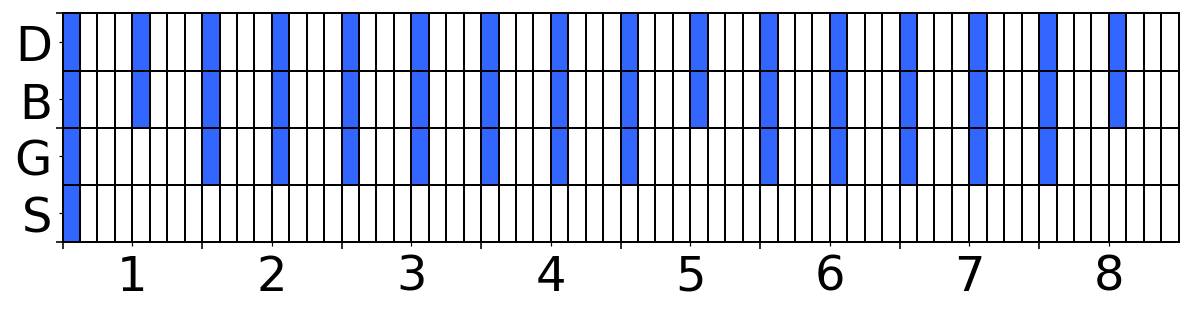

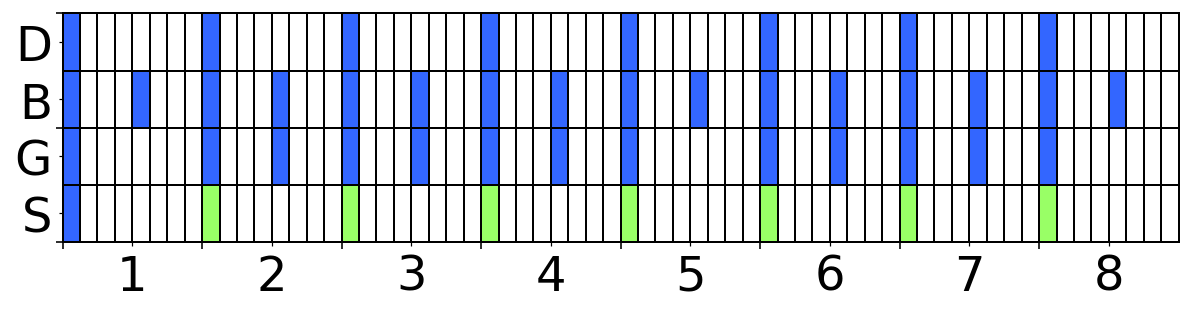

In [45]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 28
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.linewidth'] = 2

struct_z2_edit = np.copy(struct_z2)

# Drums
struct_z2_edit[0][0:2, 0] = 0
struct_z2_edit[0][0:2, 0, ::8] = 1
#struct_z2_edit[0][0:2, 0, 6::8] = 1
#struct_z2_edit[0][0:2, 0, 4] = 1
#struct_z2_edit[0][0:2, 0, 6] = 1

# Strings
struct_z2_edit[0][0, 3] = 0
struct_z2_edit[0][0:2, 3, ::8] = 0.5
struct_z2_edit[0][0, 3, 0] = 1

# Piano
#struct_z2_edit[0][0, 2] = 0
#struct_z2_edit[0][0:2, 2, ::4] = 1


s2 = struct_z2[0]
s2 = np.transpose(s2, (1, 0, 2))
s2 = s2.reshape(s2.shape[0], -1)

s2_edit = struct_z2_edit[0]
s2_edit = np.transpose(s2_edit, (1, 0, 2))
s2_edit = s2_edit.reshape(s2_edit.shape[0], -1)
print(s2.shape)

with mpl.rc_context({'lines.linewidth': 1, 'axes.linewidth': 1, 'font.size': 24}):  
    plot_struct(s2, name='generated_structure', save_dir=save_dir, figsize=(10, 2.1))
    plot_struct(s2_edit, name='edited_structure', save_dir=save_dir, figsize=(10, 2.1))
    

struct_z2_edit[0][0, 3] = 0
struct_z2_edit[0][0:2, 3, ::8] = 1
struct_z2_edit[0][0, 3, 0] = 1

In [38]:
music_real = generate_content(vae, z2, struct_z2)
music_edited = generate_content(vae, z2, struct_z2_edit)

(0.0, 0.5)
(0.0, 0.5)
(0.0, 0.5)
(0.0, 0.5)
(0.0, 0.5)
(0.0, 0.5)
(0.0, 0.5)
(0.0, 0.5)


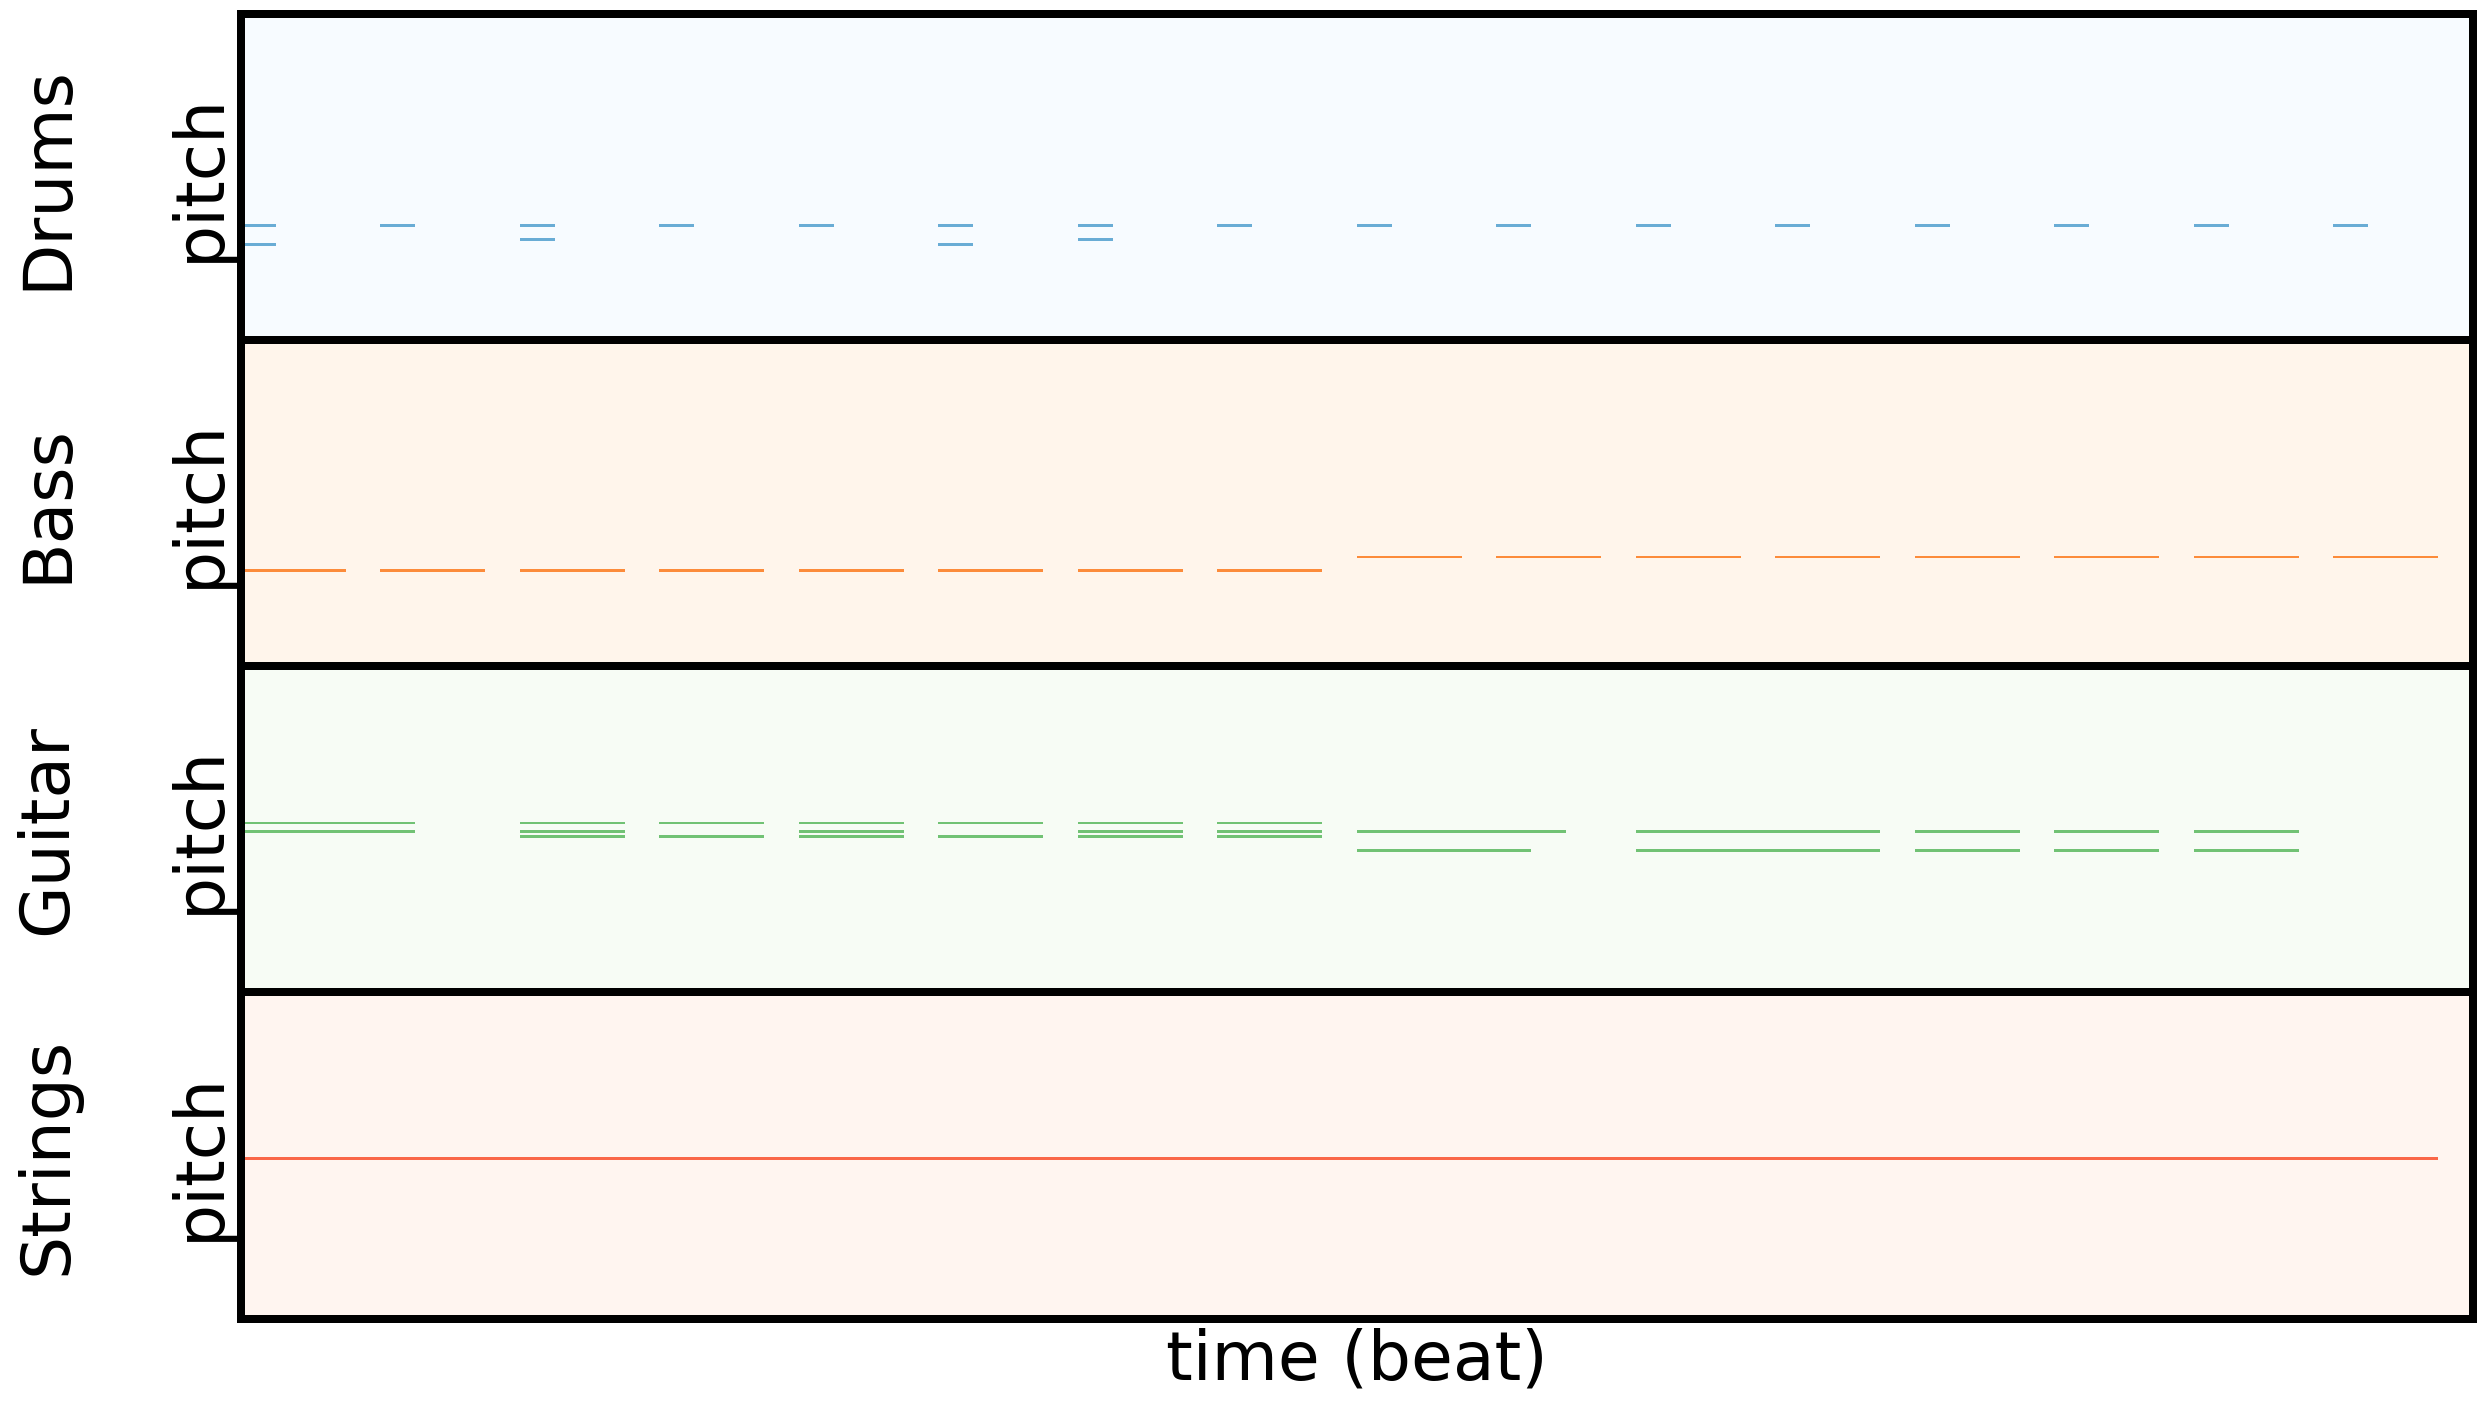

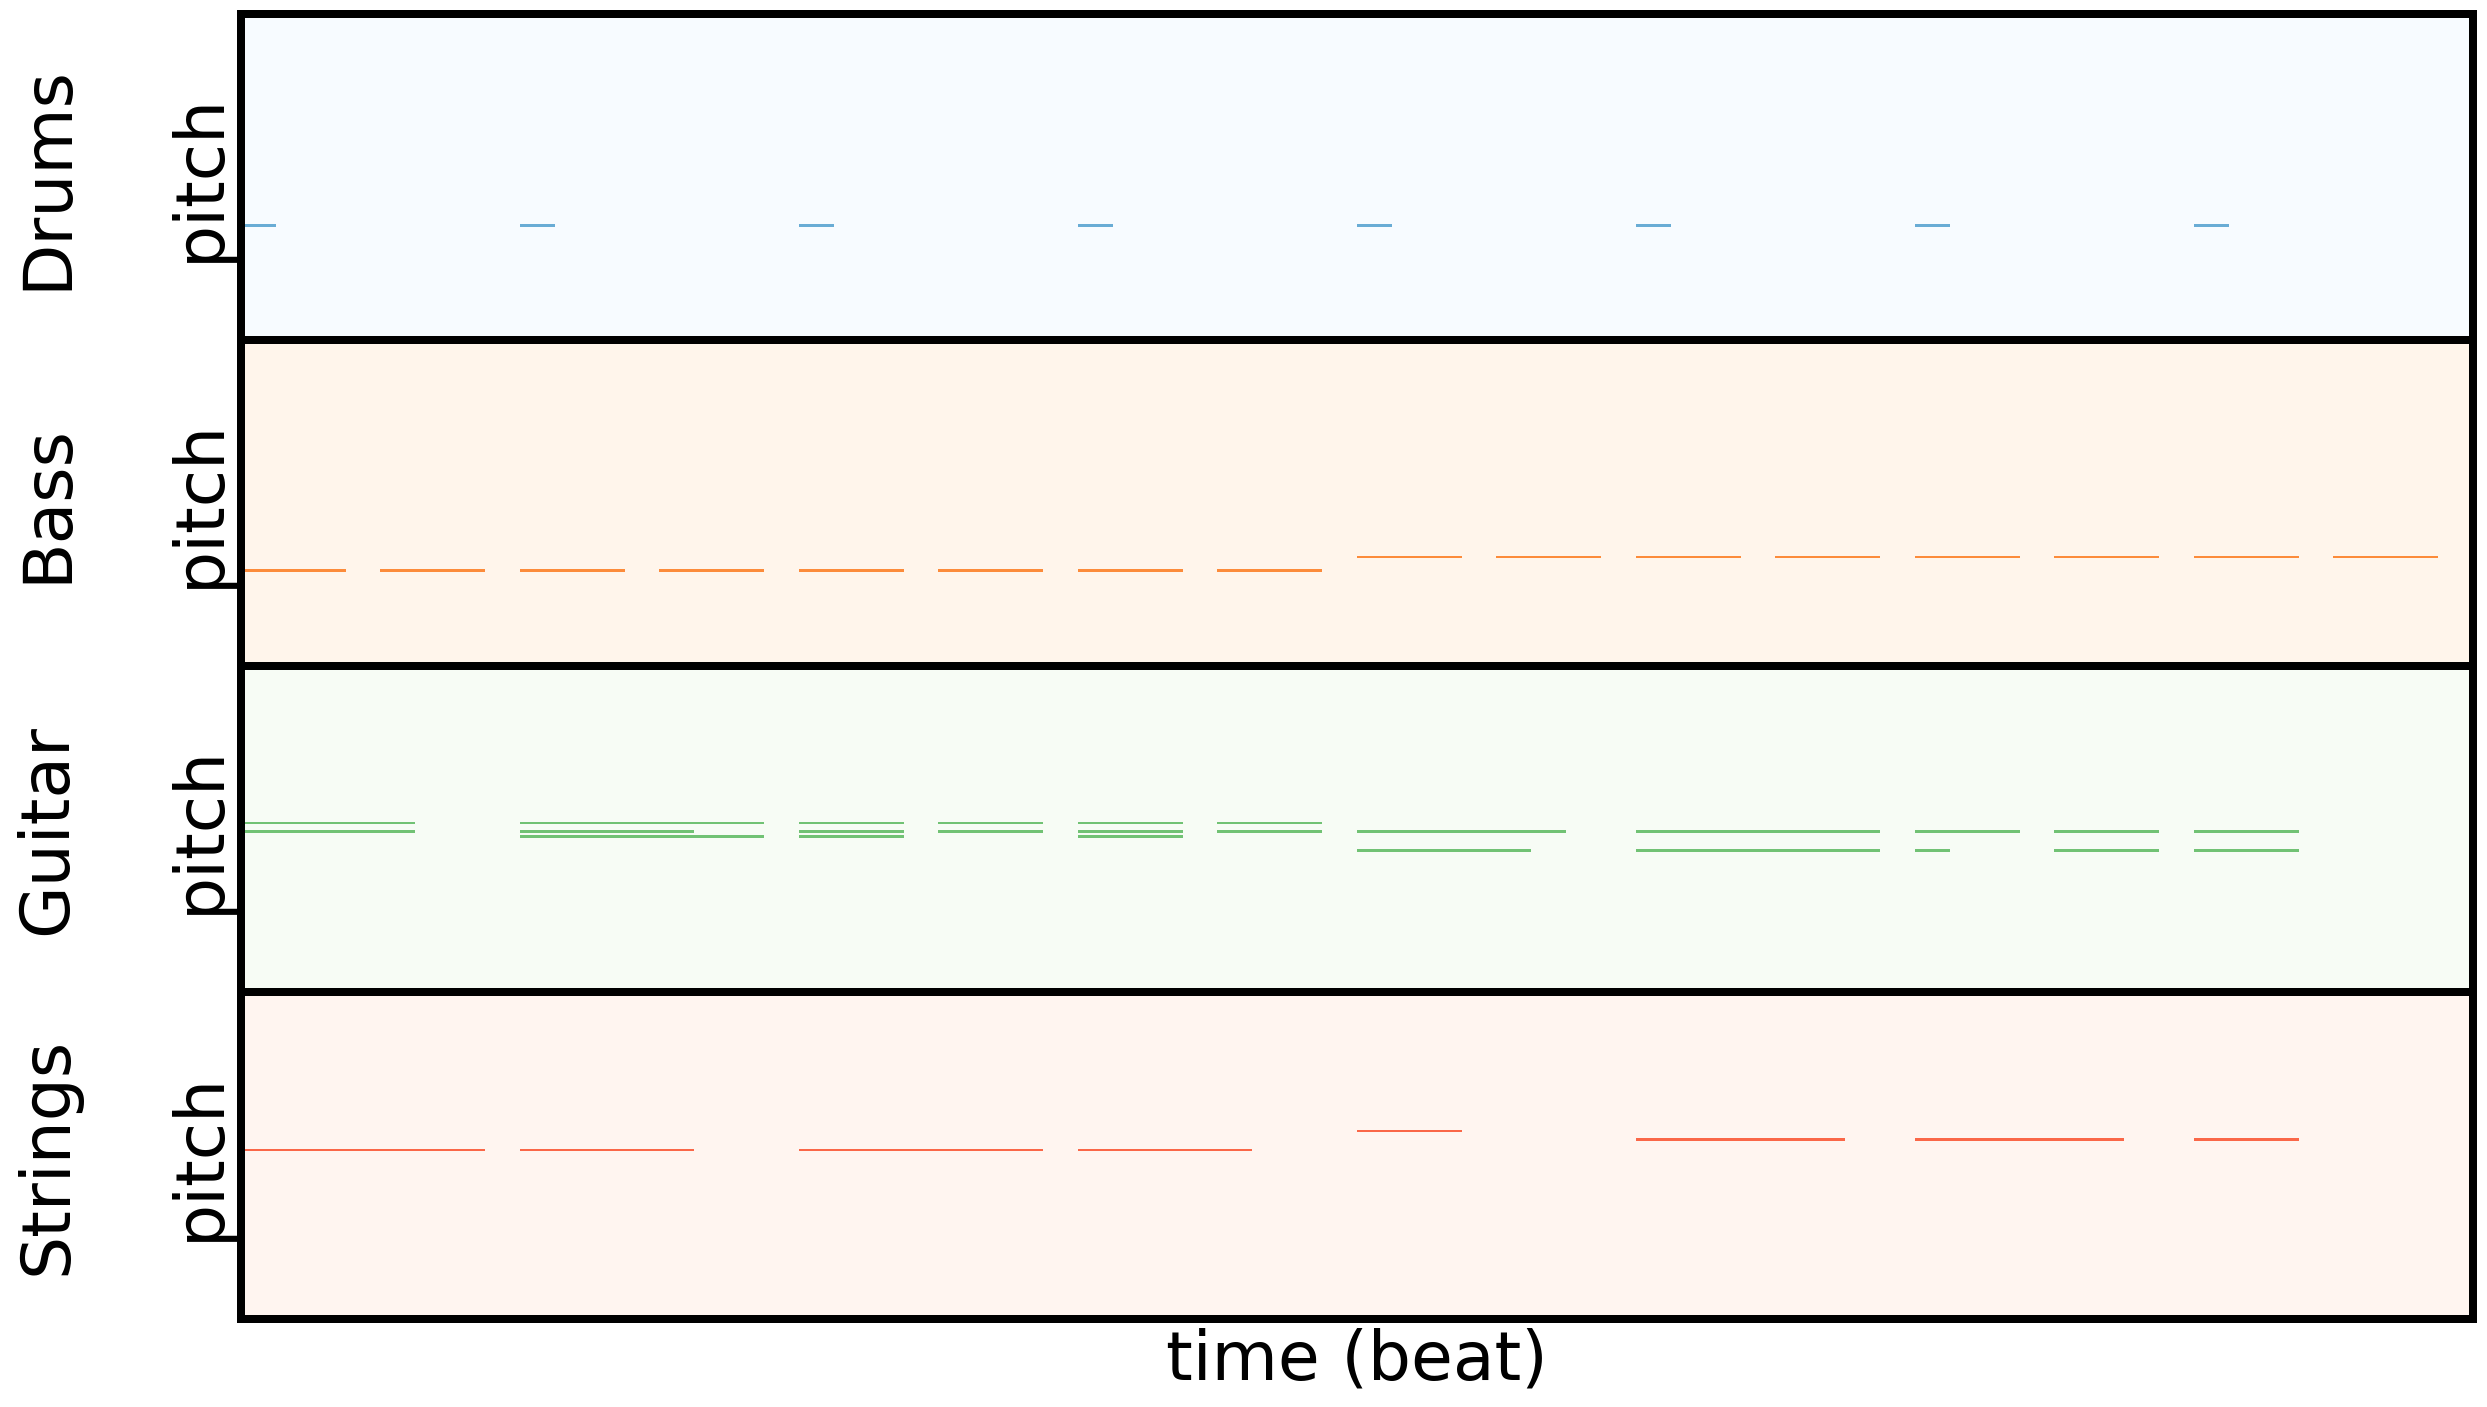

In [52]:
real = muspy_from_dense(music_real[0], track_data, params['model']['resolution'])
edited = muspy_from_dense(music_edited[0], track_data, params['model']['resolution'])

with mpl.rc_context({'lines.linewidth': 4, 'axes.linewidth': 4, 'font.size': 34}):
    plot_pianoroll(real, save_dir, name='pianoroll_generated',
                   figsize=(20, 12), fformat='png', preset='frame')
    plot_pianoroll(edited, save_dir, name='pianoroll_edited',
                   figsize=(20, 12), fformat='png', preset='frame')
    
if extend:
    edited = np.tile(music_edited[0], (1, 2, 1, 1))
    edited = muspy_from_dense(edited, track_data, params['model']['resolution'])
    real = np.tile(music_real[0], (1, 2, 1, 1))
    real = muspy_from_dense(real, track_data, params['model']['resolution'])

midi_from_muspy(edited, save_dir, name='edited_structure')
midi_from_muspy(real, save_dir, name='generated_structure')

## Latent space analysis:

In [ ]:
save_dir = 'data/plots'

#### Pitch embeddings

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib as mpl

mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Sans Serif'

# Prepare pitches/drums
tokens = torch.eye(params['model']['d_token_pitches'], device=device)

In [ ]:
# Compute embeddings
pitch_embs = vae.encoder.notes_pitch_emb(tokens)
pitch_embs = pitch_embs.detach().cpu().numpy()
pitch_embs.shape

In [ ]:
# PCA to 3D
start = 0
stop = 128
pca = PCA(n_components=3)
pca.fit(pitch_embs[start:stop])
pca_proj = pca.transform(pitch_embs[start:stop])

In [ ]:
l = np.arange(pca_proj.shape[0])

# Creating figure
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection ="3d")

# Creating plot

sc = ax.scatter3D(pca_proj[:, 0], pca_proj[:, 1], pca_proj[:, 2], c=l, cmap="copper")
ax.azim = 40 #40
ax.elev = 30 #30
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
cbar = plt.colorbar(sc, ticks=[24, 36, 48, 60, 72, 84, 96, 108], fraction=0.04, pad=0.03)
cbar.ax.set_yticklabels(['C$_1$', 'C$_2$', 'C$_3$', 'C$_4$', 'C$_5$', 'C$_6$', 'C$_7$', 'C$_8$'],
                        fontname = "monospace", fontsize=24)  # horizontal colorbar
plt.title("Pitch Embeddings", fontsize=24)
plt.savefig(os.path.join(save_dir, "pitchembs.svg"), format='svg', bbox_inches='tight', dpi=200)

#### Drums embeddings

In [ ]:
drums_embs = vae.encoder.drums_pitch_emb(tokens)
drums_embs = drums_embs.detach().cpu().numpy()
drums_embs.shape

In [ ]:
midi_notes = [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

# PCA to 2D
pca = PCA(n_components=2)
pca.fit(drums_embs[midi_notes])
pca_proj = pca.transform(drums_embs[midi_notes])
pca_proj.shape

In [ ]:
plt.scatter(pca_proj[:, 0], pca_proj[:, 1], c=midi_notes, cmap='copper')
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid()

for i, p in enumerate(midi_notes):
    plt.annotate(p, (pca_proj[i, 0], pca_proj[i, 1]))

In [ ]:
# PCA to 3D
pca = PCA(n_components=3)
pca.fit(drums_embs[midi_notes])
pca_proj = pca.transform(drums_embs[midi_notes])

In [ ]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
p = ax.scatter3D(pca_proj[:, 0], pca_proj[:, 1], pca_proj[:, 2], c=midi_notes, cmap='copper')
ax.azim = 30
ax.elev = 20
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])

fig.colorbar(p)

for i, p in enumerate(midi_notes):
    ax.text(pca_proj[i, 0], pca_proj[i, 1], pca_proj[i, 2], p)

#### Duration embeddings

In [ ]:
# Prepare pitches/drums
tokens = torch.eye(params['model']['d_token_dur'], device=device)

In [ ]:
tokens.shape

In [ ]:
dur_embs = vae.encoder.dur_emb(tokens)
dur_embs = dur_embs.detach().cpu().numpy()

In [ ]:
dur_embs.shape

In [ ]:
pca = PCA(n_components=2)
pca.fit(dur_embs[:-3])
pca_proj = pca.transform(dur_embs[:-3])

In [ ]:
pca_proj.shape

First 64 durations (2 bars) in separate cluster:

In [ ]:
n = 96
every = 1
l = np.arange(min(pca_proj.shape[0], n))

fig = plt.figure(figsize = (7, 5))
plt.scatter(pca_proj[:n:every, 0], pca_proj[:n:every, 1], c=l[::every], cmap='cool')
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
bbox_props = dict(boxstyle="round", fc="w", ec="0", alpha=0.5)
ax.text(-0.275, 1, "1 - 64", ha="center", va="center", size=20,
        bbox=bbox_props)
ax.text(0.475, 1, "65 - 96", ha="center", va="center", size=20,
        bbox=bbox_props)
#plt.xticks([], [])
#plt.yticks([], [])
plt.grid()
cbar = plt.colorbar(pad=0.02)
cbar.ax.tick_params(labelsize=20)
plt.title("Duration Embeddings\n(All)", pad=20, fontsize=24)
x1, y1 = [0.05, 0.05], [-0.75, 1.2]
plt.xlim(-0.6, 0.9), plt.ylim(-0.75, 1.2)
plt.plot(x1, y1, '--', color='black', linewidth=1.2)

every = 1

#for i in range(0, len(l), every):
#    plt.annotate(int(l[i])+1, (pca_proj[i, 0], pca_proj[i, 1]+0.01), fontsize=12)
    
plt.savefig(os.path.join(save_dir, "durembs96.svg"), format='svg', bbox_inches='tight', dpi=200)

#### Duration embeddings (only short)

In [ ]:
n = 32

pca = PCA(n_components=2)
pca.fit(dur_embs[:n])
pca_proj = pca.transform(dur_embs[:n])

In [ ]:
pca_proj.shape

8 16 24 32 divided 

In [ ]:
l = np.arange(pca_proj.shape[0])

fig = plt.figure(figsize = (7, 5))
plt.scatter(pca_proj[:n, 0], pca_proj[:n, 1], c=l, cmap='cool')
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
bbox_props = dict(boxstyle="round", fc="w", ec="0", alpha=0.5)
ax.text(-0.3, -0.15, "1 - 16", ha="center", va="center", size=20,
        bbox=bbox_props)
ax.text(0, 0.48, "17 - 24", ha="center", va="center", size=20,
        bbox=bbox_props)
ax.text(0.26, -0.28, "25 - 32", ha="center", va="center", size=20,
        bbox=bbox_props)
plt.grid()
cbar = plt.colorbar(pad=0.02)
cbar.ax.tick_params(labelsize=20)
plt.title("Duration Embeddings\n(First 32)", fontsize=24, pad=20)
x1, y1 = [-0.5, 0.3], [-0.6, -0.1]
x2, y2 = [-0.4, 0.8], [0.6, -0.6]
plt.xlim(-0.5, 0.8), plt.ylim(-0.6, 0.6)
plt.plot(x1, y1, '--', x2, y2, '--', color='black', linewidth=1.2)

#for i, dur in enumerate(l):
#   plt.annotate(int(dur)+1, (pca_proj[i, 0], pca_proj[i, 1]), fontsize=12)
    
plt.savefig(os.path.join(save_dir, "durembs32.svg"), bbox_inches='tight', format='svg', dpi=200)

In [ ]:
n = 32

pca = PCA(n_components=3)
pca.fit(dur_embs[:n])
pca_proj = pca.transform(dur_embs[:n])

In [ ]:
l = np.arange(pca_proj.shape[0])

In [ ]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
p = ax.scatter3D(pca_proj[:, 0], pca_proj[:, 1], pca_proj[:, 2], c=l)
ax.azim = 30
ax.elev = 0

fig.colorbar(p)

for i, dur in enumerate(l):
    ax.text(pca_proj[i, 0], pca_proj[i, 1], pca_proj[i, 2], int(dur)+1)

#### Chord embeddings

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pretty_midi

mpl.rcParams['font.size'] = 16

chords = [
    ['C', 'E', 'G'],
    ['C#', 'F', 'G#'],
    ['D', 'F#', 'A'],
    ['Eb', 'G', 'Bb'],
    ['E', 'G#', 'B'],
    ['F', 'A', 'C'],
    ['F#', 'A#', 'C#'],
    ['G', 'B', 'D'],
    ['Ab', 'C', 'Eb'],
    ['A', 'C#', 'E'],
    ['Bb', 'D', 'F'],
    ['B', 'D#', 'F#']
]

simu = params['model']['max_simu_notes']

chord_embs = []

for octave in range(1, 9):
    for chord in chords:
        # Prepare pitches and durs
        pitch_tokens = torch.zeros(simu-1, params['model']['d_token_pitches'], device=device)
        dur_tokens = torch.zeros(simu-1, params['model']['d_token_dur'], device=device)

        for i, note in enumerate(chord):

            note += str(octave)

            p_num = pretty_midi.note_name_to_number(note)
            pitch_tokens[i, p_num] = 1
            dur_tokens[i, 7] = 1

        # EOS
        pitch_tokens[i+1, 129] = 1
        dur_tokens[i+1, 97] = 1

        # PAD
        pitch_tokens[i+2:, 130] = 1
        dur_tokens[i+2:, 98] = 1

        # Compute chord embeddings
        pitch_embs = vae.encoder.notes_pitch_emb(pitch_tokens)

        dur_embs = vae.encoder.dur_emb(dur_tokens)

        notes_embs = torch.cat((pitch_embs, dur_embs), dim=-1)

        chord_emb = vae.encoder.chord_encoder(notes_embs.view(-1))

        chord_embs.append(chord_emb)

    
chord_embs = torch.stack(chord_embs)
chord_embs = chord_embs.detach().cpu().numpy()
print(chord_embs.shape)



In [ ]:
pca = PCA(n_components=3)
pca.fit(chord_embs)
pca_proj = pca.transform(chord_embs)

In [ ]:

l = np.arange(pca_proj.shape[0])

# Creating figure
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection ="3d")

# Creating plot

sc = ax.scatter3D(pca_proj[:, 0], pca_proj[:, 1], pca_proj[:, 2], c=l, cmap="copper")
ax.azim = 50 #40
ax.elev = 40 #30
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
cbar = plt.colorbar(sc, ticks=[1, 12, 24, 36, 48, 60, 72, 84], fraction=0.04, pad=0.03)
cbar.ax.set_yticklabels(['C$_1$', 'C$_2$', 'C$_3$', 'C$_4$', 'C$_5$', 'C$_6$', 'C$_7$', 'C$_8$'],
                        fontname='monospace', fontsize=24)   # horizontal colorbar
plt.title("Major Chord Embeddings", fontsize=24)

plt.savefig(os.path.join(save_dir, "chordembs.svg"), bbox_inches='tight', format='svg', dpi=200)

#### Distance embeddings

In [ ]:
from sklearn.decomposition import PCA


In [ ]:
# Prepare distances
distances = torch.eye(params['model']['resolution']*4, device=device)

In [ ]:
distances.shape

In [ ]:
dist_embs = vae.encoder.graph_encoder.layers[0].nn(distances)
dist_embs = dist_embs.detach().cpu().numpy()

In [ ]:
dist_embs.shape

In [ ]:
start = 0
end = 32
pca = PCA(n_components=2)
pca.fit(dist_embs[start:end])
pca_proj = pca.transform(dist_embs[start:end])

In [ ]:
pca_proj.shape

In [ ]:
mpl.rcParams['font.size'] = 12

n = 32
l = np.arange(min(pca_proj.shape[0], n))

fig = plt.figure(figsize = (10, 5))
ax = plt.scatter(pca_proj[:n, 0], pca_proj[:n, 1], c=l, cmap='copper')
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid()

plt.colorbar()

eps = 0.05
for i, dist in enumerate(l):
    plt.annotate(int(dist), (pca_proj[i, 0] - eps, pca_proj[i, 1] + 1.8*eps))


plt.savefig(os.path.join(save_dir, "distembs"), format='svg', dpi=200)

3D

In [ ]:
l = np.arange(pca_proj.shape[0])

In [ ]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
p = ax.scatter3D(pca_proj[:, 0], pca_proj[:, 1], pca_proj[:, 2], c=l)
ax.azim = 80
ax.elev = 50

fig.colorbar(p)

for i, dur in enumerate(l):
    ax.text(pca_proj[i, 0], pca_proj[i, 1], pca_proj[i, 2], int(dur))

#### Song embeddings